# Detecting spouse mentions in sentences

We will walk through an example text classification task to explore how Snorkel works with user-defined LFs. Run every cell in the notebook (unless otherwise noted) before proceeding to the next one!
## Classification Task
<img src="imgs/sentence.jpg" width="700px;">

We want to classify each __candidate__ or pair of people mentioned in a sentence, as being married at some point or not.

In the above example, our candidate represents the possible relation `(Barack Obama, Michelle Obama)`. As readers, we know this mention is true due to external knowledge and the keyword of `wedding` occuring later in the sentence.
We begin with some basic setup and data downloading.


In [1]:
%matplotlib inline

import os
import pickle
import tensorflow as tf
import numpy as np

if os.path.basename(os.getcwd()) == "snorkel-tutorials":
    os.chdir("spouse")

from utils import load_data

((dev_df, dev_labels), train_df, (test_df, test_labels)) = load_data()

/home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ubuntu/snorkel-t

/home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

**Input Data:** `dev_df` is a Pandas DataFrame object, where each row represents a particular __candidate__. The DataFrames contain the fields `sentence`, which refers to the sentence the candidate is in, `tokens`, the tokenized form of the sentence, `person1_word_idx` and `person2_word_idx`, which represent `[start, end]` indices in the tokens at which the first and second person's name appear, respectively.

We also have certain **preprocessed fields**, that we discuss a few cells below. We have other tutorials focused on generating such datasets (e.g., from richy-formatted data), but assume we have access to a Pandas DataFrame for the purpose of this specific tutorial!

In [2]:
dev_df.head()

,person1_word_idx,person2_word_idx,sentence,tokens,person1_right_tokens,person2_right_tokens,between_tokens
0,"(1, 1)","(22, 24)","The Richards are half-sisters to Kathy Hilton,...","[The, Richards, are, half, -, sisters, to, Kat...","[are, half, -, sisters]","[., ]","[are, half, -, sisters, to, Kathy, Hilton, ,, ..."
1,"(1, 1)","(7, 8)","The Richards are half-sisters to Kathy Hilton,...","[The, Richards, are, half, -, sisters, to, Kat...","[are, half, -, sisters]","[,, the, mother, of]","[are, half, -, sisters, to]"
2,"(7, 8)","(22, 24)","The Richards are half-sisters to Kathy Hilton,...","[The, Richards, are, half, -, sisters, to, Kat...","[,, the, mother, of]","[., ]","[,, the, mother, of, socialite, Paris, Hilton,..."
3,"(6, 6)","(20, 21)","Prior to both his guests, Colbert's monologue ...","[Prior, to, both, his, guests, ,, Colbert, s, ...","[s, monologue, -, parts]","[and, his, oft, -]","[s, monologue, -, parts, of, which, he, did, s..."
4,"(2, 2)","(4, 5)",People reported Williams and Ven Veen tied the...,"[People, reported, Williams, and, Ven, Veen, t...","[and, Ven, Veen, tied]","[tied, the, knot, Saturday]",[and]


You'll interact with these candidates while writing labeling functions in Snorkel. We look at a candidate in the development set:

In [3]:
from preprocessors import get_person_text

candidate = dev_df.loc[2]
person_names = get_person_text(candidate).person_names

print("Sentence: ", candidate["sentence"])
print("Person 1: ", person_names[0])
print("Person 2: ", person_names[1])

Sentence:  The Richards are half-sisters to Kathy Hilton, the mother of socialite Paris Hilton and spouse of luxury hotel magnate Richard Howard Hilton.   
Person 1:  Kathy Hilton
Person 2:  Richard Howard Hilton


# Part 2: Writing  Labeling Functions

In Snorkel, our primary interface through which we provide training signal to the end extraction model we are training is by writing **labeling functions (LFs)** (as opposed to hand-labeling massive training sets).  We'll go through some examples for our spouse classification task below.

A labeling function is a Python function that accepts a candidate, or a row of the DataFrame, as the input argument and outputs a label for the candidate. For ease of exposition in this notebook, we return `1` if it says the pair of persons in the candidate were married at some point,  `-1` if the pair of persons in the candidate were never married, and `0` if it doesn't know how to vote and abstains. In practice, many labeling functions are often unipolar: it labels only `1`s and `0`s, or it labels only `-1`s and `0`s.

(Note we will change our mapping to use `2` to represent the absence of a relationship to match the multiclass convention when feeding it to the LabelModel later.)
Recall that our goal is to ultimately train a high-performance classification model that predicts which of our candidates are true spouse relations. It turns out that we can do this by writing potentially low-quality labeling functions!

#  I. Background

## Preprocessing the Database

In a real application, there is a lot of data preparation, parsing, and database loading that needs to be completed before we dive into writing labeling functions. Here we've pre-generated candidates in a pandas DataFrame object per split (train,dev,test).

###  Using a _Development Set_ of Human-labeled Data

In our setting, we will use the phrase _development set_ to refer to a set of examples (here, a subset of our training set) which we label by hand and use to help us develop and refine labeling functions.  Unlike the _test set_, which we do not look at and use for final evaluation, we can inspect the development set while writing labeling functions. This is a list of `{-1,1}` labels.

### Labeling Function Helpers

When writing labeling functions, there are several operators you will use over and over again. In the case of text relation extraction as with this task, common operators include fetching text between mentions of the two people in a candidate, examing word windows around person mentions, etc. Note that other domains and tasks, the required preprocessors will be different.

We provide several helper functions in `preprocessors`:  these are Python helper functions that you can apply to candidates in the DataFrame to return objects that are helpful during LF development. You can (and should!) write your own helper functions to help write LFs.

We provide an example of a preprocessor definition here:

In [4]:
from snorkel.labeling.preprocess import preprocessor


@preprocessor()
def get_text_between(cand):
    """
    Returns the text between the two person mentions in the sentence for a candidate
    """
    start = cand.person1_word_idx[1] + 1
    end = cand.person2_word_idx[0]
    cand.text_between = " ".join(cand.tokens[start:end])
    return cand

## Candidate PreProcessors

We provide a set of helper functions for this task in `preprocessors.py` that take as input a candidate, or row of a DataFrame in our case. For the purpose of the tutorial, we have two of these fields preprocessed in the data, which can be used when creating labeling functions.

`get_person_text(cand)`

`get_person_lastnames(cand)`

`get_between_tokens(cand)`

`get_left_tokens(cand)`

`get_right_tokens(cand)`

II. Labeling Functions

# A. Pattern Matching Labeling Functions

One powerful form of labeling function design is defining sets of keywords or regular expressions that, as a human labeler, you know are correlated with the true label. For example, we could define a dictionary of terms that occur between person names in a candidate. One simple dictionary of terms indicating a true relation could be, which we could use in a labeling function like shown below:

    spouses = {'spouse', 'wife', 'husband', 'ex-wife', 'ex-husband'}


    @labeling_function(resources=dict(spouses=spouses), preprocessors=[get_left_tokens])
    def lf_husband_wife_left_window(x, spouses):
        if len(set(spouses).intersection(set(x.person1_left_tokens))) > 0:
            return POSITIVE
        elif len(set(spouses).intersection(set(x.person2_left_tokens))) > 0:
            return POSITIVE
        else:
            return ABSTAIN

**Note that:**
1. To access the text between the person mentions, we can use the **`get_left_tokens` preprocessor!**
2. We use **resources like the spouses dictionary** to encode themes/categories of relationships!

There are a few advantages of having preprocessors and labeling functions in this form:

**Data Agnostic:**  Operate over multiple data types without rewriting

**Incremental Processing:** Can create preprocessors as needed while writing LFs!

**Future Use:** Can store them for later for different tasks since they are reproducible and modular

**Optimizations:** Allows caching behind-the-scenes

In [5]:
from snorkel.labeling.apply import PandasLFApplier
from snorkel.labeling.lf import labeling_function

from preprocessors import get_left_tokens, get_person_last_names

POSITIVE = 1
NEGATIVE = 0
ABSTAIN = -1

In [6]:
# Check for the `spouse` words appearing between the person mentions
spouses = {"spouse", "wife", "husband", "ex-wife", "ex-husband"}


@labeling_function(resources=dict(spouses=spouses))
def lf_husband_wife(x, spouses):
    return POSITIVE if len(spouses.intersection(set(x.between_tokens))) > 0 else ABSTAIN

In [7]:
# Check for the `spouse` words appearing to the left of the person mentions
@labeling_function(resources=dict(spouses=spouses), preprocessors=[get_left_tokens])
def lf_husband_wife_left_window(x, spouses):
    if len(set(spouses).intersection(set(x.person1_left_tokens))) > 0:
        return POSITIVE
    elif len(set(spouses).intersection(set(x.person2_left_tokens))) > 0:
        return POSITIVE
    else:
        return ABSTAIN

In [8]:
# Check for the person mentions having the same last name
@labeling_function(preprocessors=[get_person_last_names])
def lf_same_last_name(x):
    p1_ln, p2_ln = x.person_lastnames

    if p1_ln and p2_ln and p1_ln == p2_ln:
        return POSITIVE
    return ABSTAIN

In [9]:
# Check for the word `married` between person mentions
@labeling_function()
def lf_married(x):
    return POSITIVE if "married" in x.between_tokens else ABSTAIN

In [10]:
# Check for words that refer to `family` relationships between and to the left of the person mentions
family = {
    "father",
    "mother",
    "sister",
    "brother",
    "son",
    "daughter",
    "grandfather",
    "grandmother",
    "uncle",
    "aunt",
    "cousin",
}
family = family.union({f + "-in-law" for f in family})


@labeling_function(resources=dict(family=family))
def lf_familial_relationship(x, family):
    return NEGATIVE if len(family.intersection(set(x.between_tokens))) > 0 else ABSTAIN


@labeling_function(resources=dict(family=family), preprocessors=[get_left_tokens])
def lf_family_left_window(x, family):
    if len(set(family).intersection(set(x.person1_left_tokens))) > 0:
        return NEGATIVE
    elif len(set(family).intersection(set(x.person2_left_tokens))) > 0:
        return NEGATIVE
    else:
        return ABSTAIN

In [11]:
# Check for `other` relationship words between person mentions
other = {"boyfriend", "girlfriend", "boss", "employee", "secretary", "co-worker"}


@labeling_function(resources=dict(other=other))
def lf_other_relationship(x, other):
    return NEGATIVE if len(other.intersection(set(x.between_tokens))) > 0 else ABSTAIN

#### Apply Labeling Functions to the Data
We create a list of labeling functions and apply them to the data

In [12]:
lfs = [
    lf_husband_wife,
    lf_husband_wife_left_window,
    lf_same_last_name,
    lf_married,
    lf_familial_relationship,
    lf_family_left_window,
    lf_other_relationship,
]
applier = PandasLFApplier(lfs)
L = applier.apply(dev_df)

  0%|          | 0/2811 [00:00<?, ?it/s]

  2%|▏         | 65/2811 [00:00<00:04, 640.01it/s]

  5%|▍         | 131/2811 [00:00<00:04, 643.83it/s]

  7%|▋         | 195/2811 [00:00<00:04, 642.08it/s]

  9%|▉         | 259/2811 [00:00<00:03, 640.51it/s]

 12%|█▏        | 325/2811 [00:00<00:03, 643.72it/s]

 14%|█▍        | 388/2811 [00:00<00:03, 639.11it/s]

 16%|█▌        | 453/2811 [00:00<00:03, 640.03it/s]

 18%|█▊        | 518/2811 [00:00<00:03, 640.72it/s]

 21%|██        | 582/2811 [00:00<00:03, 639.86it/s]

 23%|██▎       | 648/2811 [00:01<00:03, 644.11it/s]

 25%|██▌       | 713/2811 [00:01<00:03, 643.82it/s]

 28%|██▊       | 779/2811 [00:01<00:03, 645.88it/s]

 30%|███       | 844/2811 [00:01<00:03, 644.19it/s]

 32%|███▏      | 909/2811 [00:01<00:02, 645.85it/s]

 35%|███▍      | 975/2811 [00:01<00:02, 647.18it/s]

 37%|███▋      | 1040/2811 [00:01<00:02, 644.47it/s]

 39%|███▉      | 1105/2811 [00:01<00:02, 642.73it/s]

 42%|████▏     | 1171/2811 [00:01<00:02, 645.36it/s]

 44%|████▍     | 1236/2811 [00:01<00:02, 645.52it/s]

 46%|████▋     | 1302/2811 [00:02<00:02, 646.98it/s]

 49%|████▊     | 1368/2811 [00:02<00:02, 649.87it/s]

 51%|█████     | 1433/2811 [00:02<00:02, 649.51it/s]

 53%|█████▎    | 1498/2811 [00:02<00:02, 648.95it/s]

 56%|█████▌    | 1564/2811 [00:02<00:01, 649.62it/s]

 58%|█████▊    | 1629/2811 [00:02<00:01, 647.96it/s]

 60%|██████    | 1695/2811 [00:02<00:01, 648.98it/s]

 63%|██████▎   | 1760/2811 [00:02<00:01, 649.19it/s]

 65%|██████▍   | 1825/2811 [00:02<00:01, 646.51it/s]

 67%|██████▋   | 1891/2811 [00:02<00:01, 648.30it/s]

 70%|██████▉   | 1957/2811 [00:03<00:01, 649.78it/s]

 72%|███████▏  | 2022/2811 [00:03<00:01, 637.47it/s]

 74%|███████▍  | 2086/2811 [00:03<00:01, 632.80it/s]

 77%|███████▋  | 2151/2811 [00:03<00:01, 636.22it/s]

 79%|███████▉  | 2216/2811 [00:03<00:00, 639.06it/s]

 81%|████████  | 2281/2811 [00:03<00:00, 641.97it/s]

 83%|████████▎ | 2346/2811 [00:03<00:00, 643.25it/s]

 86%|████████▌ | 2412/2811 [00:03<00:00, 646.33it/s]

 88%|████████▊ | 2478/2811 [00:03<00:00, 647.49it/s]

 91%|█████████ | 2544/2811 [00:03<00:00, 648.51it/s]

 93%|█████████▎| 2609/2811 [00:04<00:00, 648.79it/s]

 95%|█████████▌| 2674/2811 [00:04<00:00, 649.11it/s]

 97%|█████████▋| 2739/2811 [00:04<00:00, 647.82it/s]

100%|█████████▉| 2804/2811 [00:04<00:00, 647.09it/s]

100%|██████████| 2811/2811 [00:04<00:00, 644.68it/s]

### Labeling Function Metrics

We can use the lf_summary function to measure various coverage related metrics for LFs. If we have gold labeled data, we can also evaluate accuracy.

#### Polarity
The set of label values the LF can output when it doesn't abstain. It is common for each LF to have a single polarity.

#### Coverage
The fraction of candidates that is labeled by our LF.

#### Overlaps
The fraction of examples labeled by the LF that is also labeled by another LF.

#### Conflicts
The fraction of examples labeled by the LF that is given a different (non-abstain) label by another LF.

#### Correct
The number of correctly labeled examples on the gold labeled data.

#### Incorrect
The number of incorrectly labeled examples on the gold labeled data.

#### Empirical Accuracy
The fraction of correctly labeled examples on the gold data.

In [13]:
from snorkel.labeling.analysis import LFAnalysis

LFAnalysis(L, lfs).lf_summary(dev_labels)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
lf_husband_wife,0,[1],0.089648,0.036642,0.017432,93,159,0.369048
lf_husband_wife_left_window,1,[1],0.025258,0.021345,0.003557,30,41,0.422535
lf_same_last_name,2,[1],0.040555,0.016009,0.008538,19,95,0.166667
lf_married,3,[1],0.019210,0.006403,0.002490,22,32,0.407407
lf_familial_relationship,4,[0],0.115617,0.051583,0.025969,310,15,0.953846
lf_family_left_window,5,[0],0.041266,0.033440,0.007826,114,2,0.982759
lf_other_relationship,6,[0],0.013874,0.002846,0.002846,33,6,0.846154


## B. Distant Supervision Labeling Functions

In addition to using factories that encode pattern matching heuristics, we can also write labeling functions that _distantly supervise_ examples. Here, we'll load in a list of known spouse pairs and check to see if the pair of persons in a candidate matches one of these.

**DBpedia**
http://wiki.dbpedia.org/
Our database of known spouses comes from DBpedia, which is a community-driven resource similar to Wikipedia but for curating structured data. We'll use a preprocessed snapshot as our knowledge base for all labeling function development.

We can look at some of the example entries from DBPedia and use them in a simple distant supervision labeling function.

Make sure `dbpedia.pkl` is in the `spouse/data` directory.

In [14]:
with open("data/dbpedia.pkl", "rb") as f:
    known_spouses = pickle.load(f)

list(known_spouses)[0:5]

[('Lena Sadler', 'William Samuel Sadler'),
 ('Bill Agee', 'Mary Cunningham Agee'),
 ('Amy Kincaid', "Liam O'Brien"),
 ('Anna Magdalena of Birkenfeld-Bischweiler',
  'Johann Reinhard II of Hanau-Lichtenberg'),
 ('Lillian Disney', 'Walt Disney')]

In [15]:
@labeling_function(
    resources=dict(known_spouses=known_spouses), preprocessors=[get_person_text]
)
def lf_distant_supervision(x, known_spouses):
    p1, p2 = x.person_names
    if (p1, p2) in known_spouses or (p2, p1) in known_spouses:
        return POSITIVE
    else:
        return ABSTAIN

In [16]:
from preprocessors import last_name

# Last name pairs for known spouses
last_names = set(
    [
        (last_name(x), last_name(y))
        for x, y in known_spouses
        if last_name(x) and last_name(y)
    ]
)


@labeling_function(
    resources=dict(last_names=last_names), preprocessors=[get_person_last_names]
)
def lf_distant_supervision_last_names(x, last_names):
    p1_ln, p2_ln = x.person_lastnames

    return (
        POSITIVE
        if (p1_ln != p2_ln)
        and ((p1_ln, p2_ln) in last_names or (p2_ln, p1_ln) in last_names)
        else ABSTAIN
    )

Every time you write a new labeling function, add it to appliers and make sure to include it in the new L matrix!

In [17]:
lfs = [
    lf_husband_wife,
    lf_husband_wife_left_window,
    lf_same_last_name,
    lf_married,
    lf_familial_relationship,
    lf_family_left_window,
    lf_other_relationship,
    lf_distant_supervision,
    lf_distant_supervision_last_names,
]
applier = PandasLFApplier(lfs)

In [18]:
dev_L = applier.apply(dev_df)

train_L = applier.apply(train_df)

  0%|          | 0/2811 [00:00<?, ?it/s]

  1%|▏         | 39/2811 [00:00<00:07, 382.78it/s]

  3%|▎         | 77/2811 [00:00<00:07, 381.64it/s]

  4%|▍         | 116/2811 [00:00<00:07, 382.77it/s]

  5%|▌         | 154/2811 [00:00<00:06, 381.83it/s]

  7%|▋         | 192/2811 [00:00<00:06, 379.94it/s]

  8%|▊         | 230/2811 [00:00<00:06, 377.64it/s]

 10%|▉         | 269/2811 [00:00<00:06, 378.97it/s]

 11%|█         | 308/2811 [00:00<00:06, 379.95it/s]

 12%|█▏        | 345/2811 [00:00<00:06, 376.08it/s]

 14%|█▎        | 383/2811 [00:01<00:06, 376.01it/s]

 15%|█▍        | 421/2811 [00:01<00:06, 375.28it/s]

 16%|█▋        | 460/2811 [00:01<00:06, 378.01it/s]

 18%|█▊        | 499/2811 [00:01<00:06, 379.81it/s]

 19%|█▉        | 537/2811 [00:01<00:05, 379.50it/s]

 20%|██        | 576/2811 [00:01<00:05, 381.01it/s]

 22%|██▏       | 615/2811 [00:01<00:05, 383.36it/s]

 23%|██▎       | 654/2811 [00:01<00:05, 383.82it/s]

 25%|██▍       | 693/2811 [00:01<00:05, 382.14it/s]

 26%|██▌       | 732/2811 [00:01<00:05, 383.42it/s]

 27%|██▋       | 771/2811 [00:02<00:05, 383.78it/s]

 29%|██▉       | 810/2811 [00:02<00:05, 382.52it/s]

 30%|███       | 849/2811 [00:02<00:05, 381.67it/s]

 32%|███▏      | 888/2811 [00:02<00:05, 382.71it/s]

 33%|███▎      | 927/2811 [00:02<00:04, 382.56it/s]

 34%|███▍      | 966/2811 [00:02<00:04, 383.26it/s]

 36%|███▌      | 1005/2811 [00:02<00:04, 380.49it/s]

 37%|███▋      | 1044/2811 [00:02<00:04, 380.04it/s]

 39%|███▊      | 1083/2811 [00:02<00:04, 379.45it/s]

 40%|███▉      | 1122/2811 [00:02<00:04, 380.90it/s]

 41%|████▏     | 1161/2811 [00:03<00:04, 381.48it/s]

 43%|████▎     | 1200/2811 [00:03<00:04, 382.15it/s]

 44%|████▍     | 1239/2811 [00:03<00:04, 381.42it/s]

 45%|████▌     | 1278/2811 [00:03<00:04, 382.33it/s]

 47%|████▋     | 1317/2811 [00:03<00:03, 382.95it/s]

 48%|████▊     | 1356/2811 [00:03<00:03, 384.49it/s]

 50%|████▉     | 1395/2811 [00:03<00:03, 385.22it/s]

 51%|█████     | 1434/2811 [00:03<00:03, 384.68it/s]

 52%|█████▏    | 1473/2811 [00:03<00:03, 384.59it/s]

 54%|█████▍    | 1512/2811 [00:03<00:03, 383.53it/s]

 55%|█████▌    | 1551/2811 [00:04<00:03, 384.12it/s]

 57%|█████▋    | 1590/2811 [00:04<00:03, 383.92it/s]

 58%|█████▊    | 1629/2811 [00:04<00:03, 381.82it/s]

 59%|█████▉    | 1668/2811 [00:04<00:02, 383.23it/s]

 61%|██████    | 1707/2811 [00:04<00:02, 382.50it/s]

 62%|██████▏   | 1746/2811 [00:04<00:02, 383.93it/s]

 64%|██████▎   | 1785/2811 [00:04<00:02, 383.53it/s]

 65%|██████▍   | 1824/2811 [00:04<00:02, 381.61it/s]

 66%|██████▋   | 1863/2811 [00:04<00:02, 382.83it/s]

 68%|██████▊   | 1902/2811 [00:04<00:02, 383.78it/s]

 69%|██████▉   | 1941/2811 [00:05<00:02, 385.05it/s]

 70%|███████   | 1980/2811 [00:05<00:02, 384.72it/s]

 72%|███████▏  | 2019/2811 [00:05<00:02, 380.67it/s]

 73%|███████▎  | 2058/2811 [00:05<00:01, 377.24it/s]

 75%|███████▍  | 2096/2811 [00:05<00:01, 378.00it/s]

 76%|███████▌  | 2135/2811 [00:05<00:01, 379.28it/s]

 77%|███████▋  | 2174/2811 [00:05<00:01, 379.64it/s]

 79%|███████▊  | 2213/2811 [00:05<00:01, 380.67it/s]

 80%|████████  | 2252/2811 [00:05<00:01, 381.41it/s]

 82%|████████▏ | 2291/2811 [00:06<00:01, 380.74it/s]

 83%|████████▎ | 2330/2811 [00:06<00:01, 381.18it/s]

 84%|████████▍ | 2369/2811 [00:06<00:01, 382.18it/s]

 86%|████████▌ | 2408/2811 [00:06<00:01, 382.78it/s]

 87%|████████▋ | 2447/2811 [00:06<00:00, 381.98it/s]

 88%|████████▊ | 2486/2811 [00:06<00:00, 383.06it/s]

 90%|████████▉ | 2525/2811 [00:06<00:00, 383.42it/s]

 91%|█████████ | 2564/2811 [00:06<00:00, 384.60it/s]

 93%|█████████▎| 2603/2811 [00:06<00:00, 384.32it/s]

 94%|█████████▍| 2642/2811 [00:06<00:00, 385.00it/s]

 95%|█████████▌| 2681/2811 [00:07<00:00, 384.48it/s]

 97%|█████████▋| 2720/2811 [00:07<00:00, 384.65it/s]

 98%|█████████▊| 2759/2811 [00:07<00:00, 383.17it/s]

100%|█████████▉| 2798/2811 [00:07<00:00, 383.39it/s]

100%|██████████| 2811/2811 [00:07<00:00, 381.73it/s]


  0%|          | 0/22254 [00:00<?, ?it/s]

  0%|          | 36/22254 [00:00<01:02, 354.78it/s]

  0%|          | 74/22254 [00:00<01:01, 361.58it/s]

  1%|          | 112/22254 [00:00<01:00, 366.70it/s]

  1%|          | 150/22254 [00:00<00:59, 368.80it/s]

  1%|          | 188/22254 [00:00<00:59, 371.45it/s]

  1%|          | 227/22254 [00:00<00:58, 374.60it/s]

  1%|          | 266/22254 [00:00<00:58, 376.52it/s]

  1%|▏         | 304/22254 [00:00<00:58, 377.38it/s]

  2%|▏         | 342/22254 [00:00<00:57, 377.82it/s]

  2%|▏         | 380/22254 [00:01<00:58, 375.82it/s]

  2%|▏         | 418/22254 [00:01<00:58, 375.97it/s]

  2%|▏         | 456/22254 [00:01<00:57, 376.58it/s]

  2%|▏         | 495/22254 [00:01<00:57, 377.67it/s]

  2%|▏         | 533/22254 [00:01<00:58, 372.94it/s]

  3%|▎         | 571/22254 [00:01<00:58, 371.30it/s]

  3%|▎         | 609/22254 [00:01<00:57, 373.56it/s]

  3%|▎         | 647/22254 [00:01<00:57, 373.86it/s]

  3%|▎         | 685/22254 [00:01<00:57, 374.17it/s]

  3%|▎         | 724/22254 [00:01<00:57, 377.06it/s]

  3%|▎         | 763/22254 [00:02<00:56, 378.41it/s]

  4%|▎         | 801/22254 [00:02<00:56, 378.75it/s]

  4%|▍         | 840/22254 [00:02<00:56, 379.66it/s]

  4%|▍         | 878/22254 [00:02<00:56, 379.50it/s]

  4%|▍         | 917/22254 [00:02<00:56, 380.84it/s]

  4%|▍         | 956/22254 [00:02<00:55, 381.71it/s]

  4%|▍         | 995/22254 [00:02<00:55, 381.49it/s]

  5%|▍         | 1034/22254 [00:02<00:55, 379.61it/s]

  5%|▍         | 1072/22254 [00:02<00:55, 379.12it/s]

  5%|▍         | 1110/22254 [00:02<00:55, 377.79it/s]

  5%|▌         | 1149/22254 [00:03<00:55, 379.22it/s]

  5%|▌         | 1188/22254 [00:03<00:55, 379.85it/s]

  6%|▌         | 1226/22254 [00:03<00:55, 378.80it/s]

  6%|▌         | 1265/22254 [00:03<00:55, 380.15it/s]

  6%|▌         | 1304/22254 [00:03<00:54, 382.16it/s]

  6%|▌         | 1343/22254 [00:03<00:54, 382.19it/s]

  6%|▌         | 1382/22254 [00:03<00:54, 382.57it/s]

  6%|▋         | 1421/22254 [00:03<00:55, 376.23it/s]

  7%|▋         | 1459/22254 [00:03<00:55, 376.24it/s]

  7%|▋         | 1497/22254 [00:03<00:55, 377.31it/s]

  7%|▋         | 1536/22254 [00:04<00:54, 378.45it/s]

  7%|▋         | 1574/22254 [00:04<00:54, 377.28it/s]

  7%|▋         | 1612/22254 [00:04<00:54, 377.40it/s]

  7%|▋         | 1650/22254 [00:04<00:54, 377.79it/s]

  8%|▊         | 1688/22254 [00:04<00:54, 378.28it/s]

  8%|▊         | 1726/22254 [00:04<00:54, 377.77it/s]

  8%|▊         | 1764/22254 [00:04<00:54, 378.00it/s]

  8%|▊         | 1803/22254 [00:04<00:53, 379.60it/s]

  8%|▊         | 1842/22254 [00:04<00:53, 380.98it/s]

  8%|▊         | 1881/22254 [00:04<00:53, 381.60it/s]

  9%|▊         | 1920/22254 [00:05<00:54, 371.31it/s]

  9%|▉         | 1958/22254 [00:05<00:54, 373.59it/s]

  9%|▉         | 1997/22254 [00:05<00:53, 375.79it/s]

  9%|▉         | 2036/22254 [00:05<00:53, 377.36it/s]

  9%|▉         | 2075/22254 [00:05<00:53, 378.36it/s]

  9%|▉         | 2113/22254 [00:05<00:53, 377.80it/s]

 10%|▉         | 2151/22254 [00:05<00:53, 377.24it/s]

 10%|▉         | 2189/22254 [00:05<00:53, 377.63it/s]

 10%|█         | 2227/22254 [00:05<00:52, 378.29it/s]

 10%|█         | 2266/22254 [00:05<00:52, 380.23it/s]

 10%|█         | 2305/22254 [00:06<00:52, 381.13it/s]

 11%|█         | 2344/22254 [00:06<00:52, 379.34it/s]

 11%|█         | 2383/22254 [00:06<00:52, 380.11it/s]

 11%|█         | 2422/22254 [00:06<00:52, 377.42it/s]

 11%|█         | 2460/22254 [00:06<00:52, 377.92it/s]

 11%|█         | 2498/22254 [00:06<00:52, 378.50it/s]

 11%|█▏        | 2536/22254 [00:06<00:52, 377.42it/s]

 12%|█▏        | 2574/22254 [00:06<00:52, 377.93it/s]

 12%|█▏        | 2612/22254 [00:06<00:51, 378.11it/s]

 12%|█▏        | 2650/22254 [00:07<00:52, 374.83it/s]

 12%|█▏        | 2688/22254 [00:07<00:52, 373.25it/s]

 12%|█▏        | 2727/22254 [00:07<00:51, 376.00it/s]

 12%|█▏        | 2765/22254 [00:07<00:51, 376.06it/s]

 13%|█▎        | 2803/22254 [00:07<00:51, 376.75it/s]

 13%|█▎        | 2841/22254 [00:07<00:51, 376.01it/s]

 13%|█▎        | 2880/22254 [00:07<00:51, 377.69it/s]

 13%|█▎        | 2919/22254 [00:07<00:50, 379.47it/s]

 13%|█▎        | 2958/22254 [00:07<00:50, 380.26it/s]

 13%|█▎        | 2997/22254 [00:07<00:50, 381.01it/s]

 14%|█▎        | 3036/22254 [00:08<00:50, 379.60it/s]

 14%|█▍        | 3075/22254 [00:08<00:50, 380.23it/s]

 14%|█▍        | 3114/22254 [00:08<00:50, 380.67it/s]

 14%|█▍        | 3153/22254 [00:08<00:50, 378.78it/s]

 14%|█▍        | 3191/22254 [00:08<00:50, 378.03it/s]

 15%|█▍        | 3230/22254 [00:08<00:50, 379.02it/s]

 15%|█▍        | 3269/22254 [00:08<00:49, 379.94it/s]

 15%|█▍        | 3308/22254 [00:08<00:49, 380.97it/s]

 15%|█▌        | 3347/22254 [00:08<00:49, 381.70it/s]

 15%|█▌        | 3386/22254 [00:08<00:49, 379.92it/s]

 15%|█▌        | 3424/22254 [00:09<00:49, 379.87it/s]

 16%|█▌        | 3462/22254 [00:09<00:49, 379.69it/s]

 16%|█▌        | 3500/22254 [00:09<00:49, 377.86it/s]

 16%|█▌        | 3538/22254 [00:09<00:49, 376.95it/s]

 16%|█▌        | 3576/22254 [00:09<00:49, 377.02it/s]

 16%|█▌        | 3615/22254 [00:09<00:49, 378.26it/s]

 16%|█▋        | 3654/22254 [00:09<00:49, 378.68it/s]

 17%|█▋        | 3693/22254 [00:09<00:48, 379.65it/s]

 17%|█▋        | 3731/22254 [00:09<00:48, 379.61it/s]

 17%|█▋        | 3769/22254 [00:09<00:48, 378.69it/s]

 17%|█▋        | 3807/22254 [00:10<00:48, 377.81it/s]

 17%|█▋        | 3846/22254 [00:10<00:48, 379.03it/s]

 17%|█▋        | 3884/22254 [00:10<00:48, 378.94it/s]

 18%|█▊        | 3923/22254 [00:10<00:48, 379.34it/s]

 18%|█▊        | 3961/22254 [00:10<00:48, 378.95it/s]

 18%|█▊        | 3999/22254 [00:10<00:48, 378.98it/s]

 18%|█▊        | 4037/22254 [00:10<00:48, 376.36it/s]

 18%|█▊        | 4076/22254 [00:10<00:48, 378.43it/s]

 18%|█▊        | 4114/22254 [00:10<00:47, 378.90it/s]

 19%|█▊        | 4152/22254 [00:10<00:47, 377.47it/s]

 19%|█▉        | 4190/22254 [00:11<00:47, 377.38it/s]

 19%|█▉        | 4228/22254 [00:11<00:47, 378.00it/s]

 19%|█▉        | 4266/22254 [00:11<00:47, 377.50it/s]

 19%|█▉        | 4305/22254 [00:11<00:47, 378.32it/s]

 20%|█▉        | 4343/22254 [00:11<00:47, 375.99it/s]

 20%|█▉        | 4381/22254 [00:11<00:47, 376.08it/s]

 20%|█▉        | 4419/22254 [00:11<00:47, 375.54it/s]

 20%|██        | 4458/22254 [00:11<00:47, 377.00it/s]

 20%|██        | 4496/22254 [00:11<00:47, 376.88it/s]

 20%|██        | 4535/22254 [00:11<00:46, 378.94it/s]

 21%|██        | 4573/22254 [00:12<00:46, 378.63it/s]

 21%|██        | 4612/22254 [00:12<00:46, 379.90it/s]

 21%|██        | 4650/22254 [00:12<00:46, 379.73it/s]

 21%|██        | 4688/22254 [00:12<00:46, 378.31it/s]

 21%|██        | 4726/22254 [00:12<00:46, 377.40it/s]

 21%|██▏       | 4764/22254 [00:12<00:46, 378.08it/s]

 22%|██▏       | 4802/22254 [00:12<00:46, 377.36it/s]

 22%|██▏       | 4841/22254 [00:12<00:45, 379.03it/s]

 22%|██▏       | 4879/22254 [00:12<00:46, 375.93it/s]

 22%|██▏       | 4917/22254 [00:13<00:46, 376.76it/s]

 22%|██▏       | 4956/22254 [00:13<00:45, 378.21it/s]

 22%|██▏       | 4994/22254 [00:13<00:45, 378.39it/s]

 23%|██▎       | 5033/22254 [00:13<00:45, 379.36it/s]

 23%|██▎       | 5071/22254 [00:13<00:45, 377.40it/s]

 23%|██▎       | 5109/22254 [00:13<00:45, 378.10it/s]

 23%|██▎       | 5147/22254 [00:13<00:45, 378.62it/s]

 23%|██▎       | 5185/22254 [00:13<00:45, 378.99it/s]

 23%|██▎       | 5223/22254 [00:13<00:45, 377.32it/s]

 24%|██▎       | 5261/22254 [00:13<00:44, 377.90it/s]

 24%|██▍       | 5299/22254 [00:14<00:44, 377.10it/s]

 24%|██▍       | 5338/22254 [00:14<00:44, 378.54it/s]

 24%|██▍       | 5376/22254 [00:14<00:44, 378.52it/s]

 24%|██▍       | 5415/22254 [00:14<00:44, 379.36it/s]

 25%|██▍       | 5454/22254 [00:14<00:44, 380.23it/s]

 25%|██▍       | 5493/22254 [00:14<00:44, 380.80it/s]

 25%|██▍       | 5532/22254 [00:14<00:43, 383.11it/s]

 25%|██▌       | 5571/22254 [00:14<00:43, 383.28it/s]

 25%|██▌       | 5610/22254 [00:14<00:44, 376.40it/s]

 25%|██▌       | 5648/22254 [00:14<00:46, 357.81it/s]

 26%|██▌       | 5686/22254 [00:15<00:45, 363.07it/s]

 26%|██▌       | 5725/22254 [00:15<00:44, 368.23it/s]

 26%|██▌       | 5764/22254 [00:15<00:44, 372.24it/s]

 26%|██▌       | 5803/22254 [00:15<00:43, 376.20it/s]

 26%|██▋       | 5842/22254 [00:15<00:43, 378.33it/s]

 26%|██▋       | 5881/22254 [00:15<00:43, 379.76it/s]

 27%|██▋       | 5920/22254 [00:15<00:43, 378.62it/s]

 27%|██▋       | 5958/22254 [00:15<00:43, 378.22it/s]

 27%|██▋       | 5996/22254 [00:15<00:42, 378.30it/s]

 27%|██▋       | 6034/22254 [00:15<00:42, 377.65it/s]

 27%|██▋       | 6072/22254 [00:16<00:42, 377.17it/s]

 27%|██▋       | 6111/22254 [00:16<00:42, 377.75it/s]

 28%|██▊       | 6149/22254 [00:16<00:42, 376.13it/s]

 28%|██▊       | 6187/22254 [00:16<00:42, 374.83it/s]

 28%|██▊       | 6225/22254 [00:16<00:42, 373.53it/s]

 28%|██▊       | 6263/22254 [00:16<00:42, 374.08it/s]

 28%|██▊       | 6302/22254 [00:16<00:42, 377.68it/s]

 28%|██▊       | 6340/22254 [00:16<00:42, 378.36it/s]

 29%|██▊       | 6378/22254 [00:16<00:41, 378.45it/s]

 29%|██▉       | 6417/22254 [00:16<00:41, 379.00it/s]

 29%|██▉       | 6455/22254 [00:17<00:41, 378.66it/s]

 29%|██▉       | 6493/22254 [00:17<00:41, 378.26it/s]

 29%|██▉       | 6532/22254 [00:17<00:41, 379.69it/s]

 30%|██▉       | 6571/22254 [00:17<00:41, 379.94it/s]

 30%|██▉       | 6609/22254 [00:17<00:41, 379.74it/s]

 30%|██▉       | 6647/22254 [00:17<00:41, 379.11it/s]

 30%|███       | 6685/22254 [00:17<00:41, 379.29it/s]

 30%|███       | 6724/22254 [00:17<00:40, 380.48it/s]

 30%|███       | 6763/22254 [00:17<00:40, 381.87it/s]

 31%|███       | 6802/22254 [00:17<00:40, 381.63it/s]

 31%|███       | 6841/22254 [00:18<00:40, 380.60it/s]

 31%|███       | 6880/22254 [00:18<00:40, 381.01it/s]

 31%|███       | 6919/22254 [00:18<00:40, 380.77it/s]

 31%|███▏      | 6958/22254 [00:18<00:40, 382.29it/s]

 31%|███▏      | 6997/22254 [00:18<00:40, 375.40it/s]

 32%|███▏      | 7036/22254 [00:18<00:40, 377.90it/s]

 32%|███▏      | 7075/22254 [00:18<00:40, 378.94it/s]

 32%|███▏      | 7113/22254 [00:18<00:40, 378.49it/s]

 32%|███▏      | 7152/22254 [00:18<00:39, 379.69it/s]

 32%|███▏      | 7190/22254 [00:19<00:39, 379.69it/s]

 32%|███▏      | 7229/22254 [00:19<00:39, 381.36it/s]

 33%|███▎      | 7268/22254 [00:19<00:39, 380.92it/s]

 33%|███▎      | 7307/22254 [00:19<00:39, 382.07it/s]

 33%|███▎      | 7346/22254 [00:19<00:39, 381.40it/s]

 33%|███▎      | 7385/22254 [00:19<00:38, 382.71it/s]

 33%|███▎      | 7424/22254 [00:19<00:38, 381.18it/s]

 34%|███▎      | 7463/22254 [00:19<00:39, 378.10it/s]

 34%|███▎      | 7501/22254 [00:19<00:39, 371.31it/s]

 34%|███▍      | 7539/22254 [00:19<00:39, 370.74it/s]

 34%|███▍      | 7578/22254 [00:20<00:39, 374.69it/s]

 34%|███▍      | 7617/22254 [00:20<00:38, 377.48it/s]

 34%|███▍      | 7656/22254 [00:20<00:38, 379.24it/s]

 35%|███▍      | 7695/22254 [00:20<00:38, 379.64it/s]

 35%|███▍      | 7734/22254 [00:20<00:38, 381.35it/s]

 35%|███▍      | 7773/22254 [00:20<00:37, 381.35it/s]

 35%|███▌      | 7812/22254 [00:20<00:37, 382.44it/s]

 35%|███▌      | 7851/22254 [00:20<00:37, 380.37it/s]

 35%|███▌      | 7890/22254 [00:20<00:37, 381.38it/s]

 36%|███▌      | 7929/22254 [00:20<00:37, 378.38it/s]

 36%|███▌      | 7967/22254 [00:21<00:37, 378.15it/s]

 36%|███▌      | 8005/22254 [00:21<00:38, 373.84it/s]

 36%|███▌      | 8044/22254 [00:21<00:37, 375.54it/s]

 36%|███▋      | 8083/22254 [00:21<00:37, 378.48it/s]

 36%|███▋      | 8122/22254 [00:21<00:37, 379.54it/s]

 37%|███▋      | 8160/22254 [00:21<00:37, 378.17it/s]

 37%|███▋      | 8198/22254 [00:21<00:37, 377.29it/s]

 37%|███▋      | 8237/22254 [00:21<00:36, 379.88it/s]

 37%|███▋      | 8276/22254 [00:21<00:36, 381.14it/s]

 37%|███▋      | 8315/22254 [00:21<00:36, 381.70it/s]

 38%|███▊      | 8354/22254 [00:22<00:36, 380.45it/s]

 38%|███▊      | 8393/22254 [00:22<00:36, 379.64it/s]

 38%|███▊      | 8432/22254 [00:22<00:36, 381.13it/s]

 38%|███▊      | 8471/22254 [00:22<00:36, 382.41it/s]

 38%|███▊      | 8510/22254 [00:22<00:36, 381.69it/s]

 38%|███▊      | 8549/22254 [00:22<00:35, 381.71it/s]

 39%|███▊      | 8588/22254 [00:22<00:35, 382.32it/s]

 39%|███▉      | 8627/22254 [00:22<00:35, 382.13it/s]

 39%|███▉      | 8666/22254 [00:22<00:35, 380.88it/s]

 39%|███▉      | 8705/22254 [00:23<00:35, 378.91it/s]

 39%|███▉      | 8743/22254 [00:23<00:35, 378.39it/s]

 39%|███▉      | 8781/22254 [00:23<00:35, 378.86it/s]

 40%|███▉      | 8820/22254 [00:23<00:35, 380.45it/s]

 40%|███▉      | 8859/22254 [00:23<00:35, 380.71it/s]

 40%|███▉      | 8898/22254 [00:23<00:35, 380.21it/s]

 40%|████      | 8937/22254 [00:23<00:35, 377.17it/s]

 40%|████      | 8975/22254 [00:23<00:35, 376.95it/s]

 41%|████      | 9013/22254 [00:23<00:35, 376.32it/s]

 41%|████      | 9051/22254 [00:23<00:35, 376.85it/s]

 41%|████      | 9090/22254 [00:24<00:34, 378.89it/s]

 41%|████      | 9128/22254 [00:24<00:34, 377.84it/s]

 41%|████      | 9166/22254 [00:24<00:34, 378.18it/s]

 41%|████▏     | 9204/22254 [00:24<00:34, 378.24it/s]

 42%|████▏     | 9242/22254 [00:24<00:34, 375.12it/s]

 42%|████▏     | 9280/22254 [00:24<00:34, 375.82it/s]

 42%|████▏     | 9319/22254 [00:24<00:34, 377.69it/s]

 42%|████▏     | 9358/22254 [00:24<00:33, 379.74it/s]

 42%|████▏     | 9397/22254 [00:24<00:33, 380.08it/s]

 42%|████▏     | 9436/22254 [00:24<00:33, 380.53it/s]

 43%|████▎     | 9475/22254 [00:25<00:33, 380.54it/s]

 43%|████▎     | 9514/22254 [00:25<00:33, 381.36it/s]

 43%|████▎     | 9553/22254 [00:25<00:33, 379.46it/s]

 43%|████▎     | 9592/22254 [00:25<00:33, 381.65it/s]

 43%|████▎     | 9631/22254 [00:25<00:33, 381.97it/s]

 43%|████▎     | 9670/22254 [00:25<00:32, 382.20it/s]

 44%|████▎     | 9709/22254 [00:25<00:32, 382.73it/s]

 44%|████▍     | 9748/22254 [00:25<00:32, 382.47it/s]

 44%|████▍     | 9787/22254 [00:25<00:32, 383.19it/s]

 44%|████▍     | 9826/22254 [00:25<00:32, 383.01it/s]

 44%|████▍     | 9865/22254 [00:26<00:32, 383.18it/s]

 45%|████▍     | 9904/22254 [00:26<00:32, 383.33it/s]

 45%|████▍     | 9943/22254 [00:26<00:32, 382.05it/s]

 45%|████▍     | 9982/22254 [00:26<00:32, 382.03it/s]

 45%|████▌     | 10021/22254 [00:26<00:31, 382.48it/s]

 45%|████▌     | 10060/22254 [00:26<00:31, 382.29it/s]

 45%|████▌     | 10099/22254 [00:26<00:31, 380.37it/s]

 46%|████▌     | 10138/22254 [00:26<00:31, 380.36it/s]

 46%|████▌     | 10177/22254 [00:26<00:31, 381.10it/s]

 46%|████▌     | 10216/22254 [00:26<00:31, 381.86it/s]

 46%|████▌     | 10255/22254 [00:27<00:31, 380.90it/s]

 46%|████▋     | 10294/22254 [00:27<00:31, 381.73it/s]

 46%|████▋     | 10333/22254 [00:27<00:31, 380.36it/s]

 47%|████▋     | 10372/22254 [00:27<00:31, 379.28it/s]

 47%|████▋     | 10410/22254 [00:27<00:31, 379.19it/s]

 47%|████▋     | 10449/22254 [00:27<00:31, 380.24it/s]

 47%|████▋     | 10488/22254 [00:27<00:30, 381.80it/s]

 47%|████▋     | 10527/22254 [00:27<00:30, 382.42it/s]

 47%|████▋     | 10566/22254 [00:27<00:30, 383.84it/s]

 48%|████▊     | 10605/22254 [00:28<00:30, 381.60it/s]

 48%|████▊     | 10644/22254 [00:28<00:30, 379.76it/s]

 48%|████▊     | 10683/22254 [00:28<00:30, 380.65it/s]

 48%|████▊     | 10722/22254 [00:28<00:30, 379.08it/s]

 48%|████▊     | 10761/22254 [00:28<00:30, 380.37it/s]

 49%|████▊     | 10800/22254 [00:28<00:30, 377.61it/s]

 49%|████▊     | 10839/22254 [00:28<00:30, 378.97it/s]

 49%|████▉     | 10878/22254 [00:28<00:29, 380.31it/s]

 49%|████▉     | 10917/22254 [00:28<00:29, 379.90it/s]

 49%|████▉     | 10956/22254 [00:28<00:29, 381.42it/s]

 49%|████▉     | 10995/22254 [00:29<00:29, 380.30it/s]

 50%|████▉     | 11034/22254 [00:29<00:29, 381.66it/s]

 50%|████▉     | 11073/22254 [00:29<00:29, 383.39it/s]

 50%|████▉     | 11112/22254 [00:29<00:29, 382.78it/s]

 50%|█████     | 11151/22254 [00:29<00:29, 381.65it/s]

 50%|█████     | 11190/22254 [00:29<00:29, 380.89it/s]

 50%|█████     | 11229/22254 [00:29<00:29, 380.03it/s]

 51%|█████     | 11268/22254 [00:29<00:28, 379.86it/s]

 51%|█████     | 11307/22254 [00:29<00:28, 380.12it/s]

 51%|█████     | 11346/22254 [00:29<00:28, 377.11it/s]

 51%|█████     | 11385/22254 [00:30<00:28, 379.76it/s]

 51%|█████▏    | 11423/22254 [00:30<00:28, 377.50it/s]

 52%|█████▏    | 11462/22254 [00:30<00:28, 379.07it/s]

 52%|█████▏    | 11500/22254 [00:30<00:28, 378.92it/s]

 52%|█████▏    | 11538/22254 [00:30<00:28, 373.94it/s]

 52%|█████▏    | 11577/22254 [00:30<00:28, 376.40it/s]

 52%|█████▏    | 11615/22254 [00:30<00:28, 376.73it/s]

 52%|█████▏    | 11654/22254 [00:30<00:28, 377.80it/s]

 53%|█████▎    | 11692/22254 [00:30<00:27, 378.03it/s]

 53%|█████▎    | 11731/22254 [00:30<00:27, 379.37it/s]

 53%|█████▎    | 11770/22254 [00:31<00:27, 380.49it/s]

 53%|█████▎    | 11809/22254 [00:31<00:27, 380.03it/s]

 53%|█████▎    | 11848/22254 [00:31<00:27, 380.31it/s]

 53%|█████▎    | 11887/22254 [00:31<00:27, 380.78it/s]

 54%|█████▎    | 11926/22254 [00:31<00:27, 380.51it/s]

 54%|█████▍    | 11965/22254 [00:31<00:27, 380.46it/s]

 54%|█████▍    | 12004/22254 [00:31<00:26, 380.99it/s]

 54%|█████▍    | 12043/22254 [00:31<00:26, 382.47it/s]

 54%|█████▍    | 12082/22254 [00:31<00:26, 382.95it/s]

 54%|█████▍    | 12121/22254 [00:31<00:26, 382.97it/s]

 55%|█████▍    | 12160/22254 [00:32<00:26, 381.70it/s]

 55%|█████▍    | 12199/22254 [00:32<00:26, 381.28it/s]

 55%|█████▍    | 12238/22254 [00:32<00:26, 382.32it/s]

 55%|█████▌    | 12277/22254 [00:32<00:26, 381.47it/s]

 55%|█████▌    | 12316/22254 [00:32<00:26, 381.86it/s]

 56%|█████▌    | 12355/22254 [00:32<00:26, 380.32it/s]

 56%|█████▌    | 12394/22254 [00:32<00:25, 380.85it/s]

 56%|█████▌    | 12433/22254 [00:32<00:25, 381.37it/s]

 56%|█████▌    | 12472/22254 [00:32<00:25, 381.41it/s]

 56%|█████▌    | 12511/22254 [00:33<00:25, 381.35it/s]

 56%|█████▋    | 12550/22254 [00:33<00:25, 381.40it/s]

 57%|█████▋    | 12589/22254 [00:33<00:25, 383.00it/s]

 57%|█████▋    | 12628/22254 [00:33<00:25, 382.00it/s]

 57%|█████▋    | 12667/22254 [00:33<00:25, 382.52it/s]

 57%|█████▋    | 12706/22254 [00:33<00:25, 381.91it/s]

 57%|█████▋    | 12745/22254 [00:33<00:24, 381.73it/s]

 57%|█████▋    | 12784/22254 [00:33<00:24, 380.20it/s]

 58%|█████▊    | 12823/22254 [00:33<00:24, 380.89it/s]

 58%|█████▊    | 12862/22254 [00:33<00:24, 380.62it/s]

 58%|█████▊    | 12901/22254 [00:34<00:24, 380.04it/s]

 58%|█████▊    | 12940/22254 [00:34<00:24, 379.98it/s]

 58%|█████▊    | 12979/22254 [00:34<00:24, 380.31it/s]

 58%|█████▊    | 13018/22254 [00:34<00:24, 380.40it/s]

 59%|█████▊    | 13057/22254 [00:34<00:24, 379.98it/s]

 59%|█████▉    | 13096/22254 [00:34<00:24, 380.36it/s]

 59%|█████▉    | 13135/22254 [00:34<00:24, 379.66it/s]

 59%|█████▉    | 13173/22254 [00:34<00:23, 378.39it/s]

 59%|█████▉    | 13211/22254 [00:34<00:23, 377.32it/s]

 60%|█████▉    | 13250/22254 [00:34<00:23, 378.26it/s]

 60%|█████▉    | 13288/22254 [00:35<00:23, 377.45it/s]

 60%|█████▉    | 13327/22254 [00:35<00:23, 379.43it/s]

 60%|██████    | 13365/22254 [00:35<00:23, 374.86it/s]

 60%|██████    | 13403/22254 [00:35<00:23, 374.02it/s]

 60%|██████    | 13442/22254 [00:35<00:23, 376.53it/s]

 61%|██████    | 13481/22254 [00:35<00:23, 378.05it/s]

 61%|██████    | 13520/22254 [00:35<00:23, 379.57it/s]

 61%|██████    | 13559/22254 [00:35<00:22, 380.27it/s]

 61%|██████    | 13598/22254 [00:35<00:22, 380.45it/s]

 61%|██████▏   | 13637/22254 [00:35<00:22, 382.68it/s]

 61%|██████▏   | 13676/22254 [00:36<00:22, 383.62it/s]

 62%|██████▏   | 13715/22254 [00:36<00:22, 382.93it/s]

 62%|██████▏   | 13754/22254 [00:36<00:22, 382.81it/s]

 62%|██████▏   | 13793/22254 [00:36<00:22, 379.74it/s]

 62%|██████▏   | 13832/22254 [00:36<00:22, 382.10it/s]

 62%|██████▏   | 13871/22254 [00:36<00:21, 383.27it/s]

 63%|██████▎   | 13910/22254 [00:36<00:21, 383.05it/s]

 63%|██████▎   | 13949/22254 [00:36<00:21, 382.90it/s]

 63%|██████▎   | 13988/22254 [00:36<00:21, 382.18it/s]

 63%|██████▎   | 14027/22254 [00:37<00:21, 381.50it/s]

 63%|██████▎   | 14066/22254 [00:37<00:21, 379.78it/s]

 63%|██████▎   | 14104/22254 [00:37<00:21, 379.70it/s]

 64%|██████▎   | 14142/22254 [00:37<00:21, 378.66it/s]

 64%|██████▎   | 14181/22254 [00:37<00:21, 380.45it/s]

 64%|██████▍   | 14220/22254 [00:37<00:21, 380.90it/s]

 64%|██████▍   | 14259/22254 [00:37<00:21, 379.91it/s]

 64%|██████▍   | 14298/22254 [00:37<00:20, 380.00it/s]

 64%|██████▍   | 14337/22254 [00:37<00:20, 380.21it/s]

 65%|██████▍   | 14376/22254 [00:37<00:20, 378.01it/s]

 65%|██████▍   | 14414/22254 [00:38<00:20, 377.52it/s]

 65%|██████▍   | 14452/22254 [00:38<00:20, 377.67it/s]

 65%|██████▌   | 14490/22254 [00:38<00:20, 376.87it/s]

 65%|██████▌   | 14529/22254 [00:38<00:20, 377.87it/s]

 65%|██████▌   | 14568/22254 [00:38<00:20, 379.60it/s]

 66%|██████▌   | 14606/22254 [00:38<00:20, 378.06it/s]

 66%|██████▌   | 14645/22254 [00:38<00:19, 380.49it/s]

 66%|██████▌   | 14684/22254 [00:38<00:19, 380.46it/s]

 66%|██████▌   | 14723/22254 [00:38<00:19, 382.05it/s]

 66%|██████▋   | 14762/22254 [00:38<00:19, 382.50it/s]

 67%|██████▋   | 14801/22254 [00:39<00:19, 382.74it/s]

 67%|██████▋   | 14840/22254 [00:39<00:20, 369.35it/s]

 67%|██████▋   | 14878/22254 [00:39<00:19, 370.91it/s]

 67%|██████▋   | 14917/22254 [00:39<00:19, 373.91it/s]

 67%|██████▋   | 14956/22254 [00:39<00:19, 376.10it/s]

 67%|██████▋   | 14995/22254 [00:39<00:19, 378.60it/s]

 68%|██████▊   | 15034/22254 [00:39<00:18, 380.80it/s]

 68%|██████▊   | 15073/22254 [00:39<00:18, 381.90it/s]

 68%|██████▊   | 15112/22254 [00:39<00:18, 381.24it/s]

 68%|██████▊   | 15151/22254 [00:39<00:18, 380.45it/s]

 68%|██████▊   | 15190/22254 [00:40<00:18, 381.34it/s]

 68%|██████▊   | 15229/22254 [00:40<00:18, 379.28it/s]

 69%|██████▊   | 15268/22254 [00:40<00:18, 380.27it/s]

 69%|██████▉   | 15307/22254 [00:40<00:18, 380.44it/s]

 69%|██████▉   | 15346/22254 [00:40<00:18, 380.60it/s]

 69%|██████▉   | 15385/22254 [00:40<00:18, 380.63it/s]

 69%|██████▉   | 15424/22254 [00:40<00:17, 381.60it/s]

 69%|██████▉   | 15463/22254 [00:40<00:17, 381.75it/s]

 70%|██████▉   | 15502/22254 [00:40<00:17, 381.87it/s]

 70%|██████▉   | 15541/22254 [00:40<00:17, 381.30it/s]

 70%|███████   | 15580/22254 [00:41<00:17, 380.01it/s]

 70%|███████   | 15619/22254 [00:41<00:17, 379.34it/s]

 70%|███████   | 15658/22254 [00:41<00:17, 380.72it/s]

 71%|███████   | 15697/22254 [00:41<00:17, 376.64it/s]

 71%|███████   | 15735/22254 [00:41<00:17, 377.26it/s]

 71%|███████   | 15773/22254 [00:41<00:17, 376.29it/s]

 71%|███████   | 15811/22254 [00:41<00:17, 377.25it/s]

 71%|███████   | 15849/22254 [00:41<00:16, 377.36it/s]

 71%|███████▏  | 15888/22254 [00:41<00:16, 379.94it/s]

 72%|███████▏  | 15927/22254 [00:42<00:16, 380.15it/s]

 72%|███████▏  | 15966/22254 [00:42<00:16, 380.40it/s]

 72%|███████▏  | 16005/22254 [00:42<00:16, 379.24it/s]

 72%|███████▏  | 16043/22254 [00:42<00:16, 377.18it/s]

 72%|███████▏  | 16081/22254 [00:42<00:16, 377.04it/s]

 72%|███████▏  | 16119/22254 [00:42<00:16, 377.25it/s]

 73%|███████▎  | 16157/22254 [00:42<00:16, 374.69it/s]

 73%|███████▎  | 16195/22254 [00:42<00:16, 376.17it/s]

 73%|███████▎  | 16233/22254 [00:42<00:15, 376.65it/s]

 73%|███████▎  | 16272/22254 [00:42<00:15, 377.82it/s]

 73%|███████▎  | 16310/22254 [00:43<00:15, 378.31it/s]

 73%|███████▎  | 16349/22254 [00:43<00:15, 379.39it/s]

 74%|███████▎  | 16388/22254 [00:43<00:15, 379.86it/s]

 74%|███████▍  | 16427/22254 [00:43<00:15, 380.15it/s]

 74%|███████▍  | 16466/22254 [00:43<00:15, 380.45it/s]

 74%|███████▍  | 16505/22254 [00:43<00:15, 380.65it/s]

 74%|███████▍  | 16544/22254 [00:43<00:14, 380.81it/s]

 75%|███████▍  | 16583/22254 [00:43<00:14, 379.91it/s]

 75%|███████▍  | 16621/22254 [00:43<00:15, 371.22it/s]

 75%|███████▍  | 16659/22254 [00:43<00:15, 371.44it/s]

 75%|███████▌  | 16697/22254 [00:44<00:14, 373.91it/s]

 75%|███████▌  | 16736/22254 [00:44<00:14, 376.54it/s]

 75%|███████▌  | 16775/22254 [00:44<00:14, 378.18it/s]

 76%|███████▌  | 16814/22254 [00:44<00:14, 379.97it/s]

 76%|███████▌  | 16853/22254 [00:44<00:14, 382.31it/s]

 76%|███████▌  | 16892/22254 [00:44<00:14, 376.87it/s]

 76%|███████▌  | 16930/22254 [00:44<00:14, 376.42it/s]

 76%|███████▋  | 16969/22254 [00:44<00:13, 377.96it/s]

 76%|███████▋  | 17007/22254 [00:44<00:13, 378.44it/s]

 77%|███████▋  | 17046/22254 [00:44<00:13, 379.17it/s]

 77%|███████▋  | 17085/22254 [00:45<00:13, 380.52it/s]

 77%|███████▋  | 17124/22254 [00:45<00:13, 380.22it/s]

 77%|███████▋  | 17163/22254 [00:45<00:13, 380.42it/s]

 77%|███████▋  | 17202/22254 [00:45<00:13, 376.63it/s]

 77%|███████▋  | 17240/22254 [00:45<00:13, 375.36it/s]

 78%|███████▊  | 17279/22254 [00:45<00:13, 377.16it/s]

 78%|███████▊  | 17318/22254 [00:45<00:13, 378.41it/s]

 78%|███████▊  | 17357/22254 [00:45<00:12, 379.66it/s]

 78%|███████▊  | 17395/22254 [00:45<00:12, 377.22it/s]

 78%|███████▊  | 17433/22254 [00:46<00:12, 377.60it/s]

 79%|███████▊  | 17471/22254 [00:46<00:12, 378.08it/s]

 79%|███████▊  | 17509/22254 [00:46<00:12, 376.34it/s]

 79%|███████▉  | 17548/22254 [00:46<00:12, 379.03it/s]

 79%|███████▉  | 17587/22254 [00:46<00:12, 380.34it/s]

 79%|███████▉  | 17626/22254 [00:46<00:12, 380.52it/s]

 79%|███████▉  | 17665/22254 [00:46<00:12, 382.31it/s]

 80%|███████▉  | 17704/22254 [00:46<00:11, 382.63it/s]

 80%|███████▉  | 17743/22254 [00:46<00:11, 382.28it/s]

 80%|███████▉  | 17782/22254 [00:46<00:11, 381.82it/s]

 80%|████████  | 17821/22254 [00:47<00:11, 381.64it/s]

 80%|████████  | 17860/22254 [00:47<00:11, 382.57it/s]

 80%|████████  | 17899/22254 [00:47<00:11, 381.84it/s]

 81%|████████  | 17938/22254 [00:47<00:11, 379.69it/s]

 81%|████████  | 17976/22254 [00:47<00:11, 378.32it/s]

 81%|████████  | 18014/22254 [00:47<00:11, 377.42it/s]

 81%|████████  | 18053/22254 [00:47<00:11, 379.63it/s]

 81%|████████▏ | 18092/22254 [00:47<00:10, 380.56it/s]

 81%|████████▏ | 18131/22254 [00:47<00:10, 381.46it/s]

 82%|████████▏ | 18170/22254 [00:47<00:10, 379.78it/s]

 82%|████████▏ | 18208/22254 [00:48<00:10, 379.11it/s]

 82%|████████▏ | 18246/22254 [00:48<00:10, 379.05it/s]

 82%|████████▏ | 18285/22254 [00:48<00:10, 380.40it/s]

 82%|████████▏ | 18324/22254 [00:48<00:10, 381.02it/s]

 83%|████████▎ | 18363/22254 [00:48<00:10, 381.58it/s]

 83%|████████▎ | 18402/22254 [00:48<00:10, 382.32it/s]

 83%|████████▎ | 18441/22254 [00:48<00:09, 382.73it/s]

 83%|████████▎ | 18480/22254 [00:48<00:09, 382.19it/s]

 83%|████████▎ | 18519/22254 [00:48<00:09, 381.10it/s]

 83%|████████▎ | 18558/22254 [00:48<00:09, 380.68it/s]

 84%|████████▎ | 18597/22254 [00:49<00:09, 379.87it/s]

 84%|████████▎ | 18636/22254 [00:49<00:09, 380.14it/s]

 84%|████████▍ | 18675/22254 [00:49<00:09, 380.40it/s]

 84%|████████▍ | 18714/22254 [00:49<00:09, 379.40it/s]

 84%|████████▍ | 18753/22254 [00:49<00:09, 379.91it/s]

 84%|████████▍ | 18792/22254 [00:49<00:09, 380.58it/s]

 85%|████████▍ | 18831/22254 [00:49<00:09, 380.04it/s]

 85%|████████▍ | 18870/22254 [00:49<00:08, 380.43it/s]

 85%|████████▍ | 18909/22254 [00:49<00:08, 380.02it/s]

 85%|████████▌ | 18948/22254 [00:49<00:08, 381.04it/s]

 85%|████████▌ | 18987/22254 [00:50<00:08, 380.05it/s]

 85%|████████▌ | 19026/22254 [00:50<00:08, 381.06it/s]

 86%|████████▌ | 19065/22254 [00:50<00:08, 381.64it/s]

 86%|████████▌ | 19104/22254 [00:50<00:08, 381.00it/s]

 86%|████████▌ | 19143/22254 [00:50<00:08, 379.78it/s]

 86%|████████▌ | 19181/22254 [00:50<00:08, 379.65it/s]

 86%|████████▋ | 19219/22254 [00:50<00:07, 379.48it/s]

 87%|████████▋ | 19257/22254 [00:50<00:07, 378.89it/s]

 87%|████████▋ | 19296/22254 [00:50<00:07, 379.68it/s]

 87%|████████▋ | 19334/22254 [00:51<00:07, 378.98it/s]

 87%|████████▋ | 19373/22254 [00:51<00:07, 379.76it/s]

 87%|████████▋ | 19412/22254 [00:51<00:07, 380.65it/s]

 87%|████████▋ | 19451/22254 [00:51<00:07, 382.33it/s]

 88%|████████▊ | 19490/22254 [00:51<00:07, 380.34it/s]

 88%|████████▊ | 19529/22254 [00:51<00:07, 380.78it/s]

 88%|████████▊ | 19568/22254 [00:51<00:07, 379.38it/s]

 88%|████████▊ | 19607/22254 [00:51<00:06, 380.83it/s]

 88%|████████▊ | 19646/22254 [00:51<00:06, 380.83it/s]

 88%|████████▊ | 19685/22254 [00:51<00:06, 378.94it/s]

 89%|████████▊ | 19724/22254 [00:52<00:06, 381.51it/s]

 89%|████████▉ | 19763/22254 [00:52<00:06, 381.58it/s]

 89%|████████▉ | 19802/22254 [00:52<00:06, 381.09it/s]

 89%|████████▉ | 19841/22254 [00:52<00:06, 381.36it/s]

 89%|████████▉ | 19880/22254 [00:52<00:06, 379.15it/s]

 90%|████████▉ | 19919/22254 [00:52<00:06, 380.01it/s]

 90%|████████▉ | 19958/22254 [00:52<00:06, 381.35it/s]

 90%|████████▉ | 19997/22254 [00:52<00:05, 378.60it/s]

 90%|█████████ | 20036/22254 [00:52<00:05, 379.19it/s]

 90%|█████████ | 20075/22254 [00:52<00:05, 380.39it/s]

 90%|█████████ | 20114/22254 [00:53<00:05, 379.57it/s]

 91%|█████████ | 20153/22254 [00:53<00:05, 380.13it/s]

 91%|█████████ | 20192/22254 [00:53<00:05, 380.90it/s]

 91%|█████████ | 20231/22254 [00:53<00:05, 379.52it/s]

 91%|█████████ | 20269/22254 [00:53<00:05, 377.70it/s]

 91%|█████████▏| 20307/22254 [00:53<00:05, 366.26it/s]

 91%|█████████▏| 20346/22254 [00:53<00:05, 371.00it/s]

 92%|█████████▏| 20384/22254 [00:53<00:05, 372.69it/s]

 92%|█████████▏| 20423/22254 [00:53<00:04, 375.27it/s]

 92%|█████████▏| 20461/22254 [00:53<00:04, 376.65it/s]

 92%|█████████▏| 20499/22254 [00:54<00:04, 377.33it/s]

 92%|█████████▏| 20538/22254 [00:54<00:04, 379.19it/s]

 92%|█████████▏| 20577/22254 [00:54<00:04, 379.74it/s]

 93%|█████████▎| 20615/22254 [00:54<00:04, 378.90it/s]

 93%|█████████▎| 20654/22254 [00:54<00:04, 379.69it/s]

 93%|█████████▎| 20693/22254 [00:54<00:04, 380.17it/s]

 93%|█████████▎| 20732/22254 [00:54<00:04, 379.31it/s]

 93%|█████████▎| 20771/22254 [00:54<00:03, 379.89it/s]

 94%|█████████▎| 20810/22254 [00:54<00:03, 380.11it/s]

 94%|█████████▎| 20849/22254 [00:54<00:03, 377.65it/s]

 94%|█████████▍| 20887/22254 [00:55<00:03, 378.17it/s]

 94%|█████████▍| 20926/22254 [00:55<00:03, 379.37it/s]

 94%|█████████▍| 20965/22254 [00:55<00:03, 380.42it/s]

 94%|█████████▍| 21004/22254 [00:55<00:03, 379.77it/s]

 95%|█████████▍| 21043/22254 [00:55<00:03, 380.88it/s]

 95%|█████████▍| 21082/22254 [00:55<00:03, 379.85it/s]

 95%|█████████▍| 21120/22254 [00:55<00:02, 379.88it/s]

 95%|█████████▌| 21159/22254 [00:55<00:02, 380.42it/s]

 95%|█████████▌| 21198/22254 [00:55<00:02, 379.69it/s]

 95%|█████████▌| 21236/22254 [00:56<00:02, 379.13it/s]

 96%|█████████▌| 21275/22254 [00:56<00:02, 379.85it/s]

 96%|█████████▌| 21314/22254 [00:56<00:02, 380.96it/s]

 96%|█████████▌| 21353/22254 [00:56<00:02, 380.50it/s]

 96%|█████████▌| 21392/22254 [00:56<00:02, 381.13it/s]

 96%|█████████▋| 21431/22254 [00:56<00:02, 382.30it/s]

 96%|█████████▋| 21470/22254 [00:56<00:02, 377.68it/s]

 97%|█████████▋| 21508/22254 [00:56<00:01, 377.58it/s]

 97%|█████████▋| 21547/22254 [00:56<00:01, 378.53it/s]

 97%|█████████▋| 21585/22254 [00:56<00:01, 377.39it/s]

 97%|█████████▋| 21624/22254 [00:57<00:01, 378.86it/s]

 97%|█████████▋| 21663/22254 [00:57<00:01, 379.54it/s]

 98%|█████████▊| 21701/22254 [00:57<00:01, 379.38it/s]

 98%|█████████▊| 21740/22254 [00:57<00:01, 380.29it/s]

 98%|█████████▊| 21779/22254 [00:57<00:01, 379.81it/s]

 98%|█████████▊| 21817/22254 [00:57<00:01, 378.72it/s]

 98%|█████████▊| 21855/22254 [00:57<00:01, 378.68it/s]

 98%|█████████▊| 21893/22254 [00:57<00:00, 378.41it/s]

 99%|█████████▊| 21931/22254 [00:57<00:00, 378.31it/s]

 99%|█████████▊| 21970/22254 [00:57<00:00, 379.09it/s]

 99%|█████████▉| 22008/22254 [00:58<00:00, 376.71it/s]

 99%|█████████▉| 22046/22254 [00:58<00:00, 371.99it/s]

 99%|█████████▉| 22084/22254 [00:58<00:00, 369.11it/s]

 99%|█████████▉| 22122/22254 [00:58<00:00, 371.67it/s]

100%|█████████▉| 22160/22254 [00:58<00:00, 373.86it/s]

100%|█████████▉| 22198/22254 [00:58<00:00, 374.82it/s]

100%|█████████▉| 22237/22254 [00:58<00:00, 376.77it/s]

100%|██████████| 22254/22254 [00:58<00:00, 378.99it/s]

## C. Writing Custom Labeling Functions

The strength of LFs is that you can write any arbitrary function and use it to supervise a classification task. This approach can combine many of the same strategies discussed above or encode other information.

For example, we observe that when mentions of person names occur far apart in a sentence, this is a good indicator that the candidate's label is False. You can write a labeling function that uses preprocessor `get_text_between` or `get_between_tokens`!

**IMPORTANT** Good labeling functions manage a trade-off between high coverage and high precision. When constructing your dictionaries, think about building larger, noiser sets of terms instead of relying on 1 or 2 keywords. Sometimes a single word can be very predictive (e.g., `ex-wife`) but it's almost always better to define something more general, such as a regular expression pattern capturing _any_ string with the `ex-` prefix.

**Try editing and running the cells below!**

In [19]:
# @labeling_function()
# def lf_new(x):
#     return POSITIVE if x.person1_word_idx[0] > 3 else ABSTAIN
#
# applier = PandasLFApplier([lf_new])

In [20]:
# new_dev_L = applier.apply(dev_df)
# dev_L = np.concatenate((dev_L, new_dev_L), axis=1)
#
# new_train_L = applier.apply(train_df)
# train_L = np.concatenate((train_L, new_train_L), axis=1)

## Part 3: Training the Label Model

Now, we'll train a model of the LFs to estimate their accuracies. Once the model is trained, we can combine the outputs of the LFs into a single, noise-aware training label set for our extractor. Intuitively, we'll model the LFs by observing how they overlap and conflict with each other.

## Label Model
We know that our labeling functions will not be perfect, and some may be quite low-quality, so we will _model_ their accuracies with a factor-graph based label model, which Snorkel will help us easily apply.

This will ultimately produce a single set of **noise-aware training labels**, which are probabilistic or confidence-weighted labels. We will then use these labels to train an end extraction model in the next notebook.  For more technical details of this overall approach, see our [NeurIPS 2016](https://arxiv.org/abs/1605.07723) and [AAAI 2019](https://arxiv.org/abs/1810.02840) papers.

### 1. Training the Model
When training the generative model, we use convert_labels with arguments `plusminus` and `categorical` to map our labeling convention from `{0,-1,1}` in the labeling functions to `{0,1,2}` as required by the `LabelModel`.

**Parameter Definitions**

    cardinality  Cardinality, or the number of classes in the task
    lr  The factor by which we update model weights after computing the gradient
    class_balance Proportion of [positive, negative] samples in the dataset
    n_epochs     A single pass through all the data in your training set

In [21]:
from snorkel.labeling.model.label_model import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(train_L, dev_labels, n_epochs=5000, log_freq=500, seed=123)

Computing O...
Estimating \mu...
[0 epochs]: TRAIN:[loss=0.009]


[500 epochs]: TRAIN:[loss=0.001]


[1000 epochs]: TRAIN:[loss=0.001]


[1500 epochs]: TRAIN:[loss=0.001]


[2000 epochs]: TRAIN:[loss=0.001]


[2500 epochs]: TRAIN:[loss=0.001]


[3000 epochs]: TRAIN:[loss=0.001]


[3500 epochs]: TRAIN:[loss=0.001]


[4000 epochs]: TRAIN:[loss=0.001]


[4500 epochs]: TRAIN:[loss=0.001]


Finished Training


### Label Model Accuracy
This is the accuracy of the labels inferred by the Label Model.

In [22]:
from snorkel.analysis.metrics import metric_score
from snorkel.analysis.utils import probs_to_preds

Y_probs_dev = label_model.predict_proba(dev_L)
Y_preds_dev = probs_to_preds(Y_probs_dev)
print(
    f"Label model accuracy: {metric_score(dev_labels, Y_preds_dev, probs=Y_probs_dev, metric='accuracy')}"
)
print(
    f"Label model f1 score: {metric_score(dev_labels, Y_preds_dev, probs=Y_probs_dev, metric='f1')}"
)

Label model accuracy: 0.9206688011383849
Label model f1 score: 0.2875399361022364


### Plotting Probabilistic Labels
One immediate santity check  you can peform using the generative model is to visually examine the distribution of predicted training probabilistic labels. Ideally, there should get a bimodal distribution with large seperation between each peaks, as shown below by the far **right** image. The corresponds to good signal for true and positive class labels. For your first Snorkel application, you'll probably see probabilistic labels closer to the far left or middle images. With all mass centered around p=0.5, as shown on the **left**, you probably need to write more LFs got get more overall _coverage_. In the **middle** image, you have good negative coverage, but not enough positive LFs

<img align="left" src="imgs/marginals-common.jpg" width="320px" style="margin-left:0px">

<img align="left" src="imgs/marginals-real.jpg" width="320px" style="margin-right:0px">

<img align="right" src="imgs/marginals-ideal.jpg" width="320px" style="margin-right:0px">

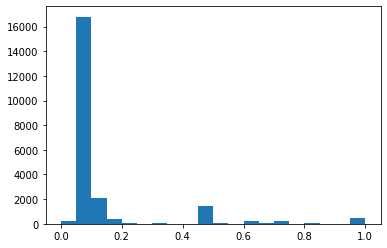

In [23]:
import matplotlib.pyplot as plt

train_proba = label_model.predict_proba(train_L)
plt.hist(train_proba[:, 1], bins=20, range=(0.0, 1.0))
plt.show()

## Part 4: Training our End Extraction Model

In this final section of the tutorial, we'll use our noisy training labels alongside the development set labels to train our end machine learning model. We start by filtering out training examples which did not recieve a label from any LF, as these examples contain no signal. Then we concatenate them with dev set examples.


In [24]:
import pandas as pd
from snorkel.analysis.utils import preds_to_probs

# Change dev labels 1D array to 2D probabilities array as required for training end model.
dev_label_probs = preds_to_probs(dev_labels, 2)
mask = train_L.max(1) != -1
combined_df = pd.concat([dev_df, train_df.iloc[mask]])
combined_proba = np.concatenate([dev_label_probs, train_proba[mask, :]], 0)

## II. Training a _Long Short-term Memory_ (LSTM) Neural Network

[LSTMs](https://en.wikipedia.org/wiki/Long_short-term_memory) can acheive state-of-the-art performance on many text classification tasks. We'll train a simple LSTM model below. tf_model contains functions for processing features and building the tensorflow graphs for training and evaluation.

For this tutorial, we will be training a fairly effective deep learning model. More generally, however, Snorkel plugs in with many ML libraries, making it easy to use almost any state-of-the-art model as the end model!

In [25]:
from tf_model import get_features_and_labels, get_model

model = get_model()
tokens, idx1, idx2, label_probs = get_features_and_labels(
    combined_df, combined_proba, tf.float32
)
batch_size = 64
num_epochs = 2  # TODO: Change this to ~10. Warning: Training takes tens of minutes!
model.fit(
    (tokens, idx1, idx2),
    label_probs,
    batch_size=batch_size,
    steps_per_epoch=(len(train_df) // batch_size),
    epochs=num_epochs,
)

W0726 20:58:44.086762 140176366790464 deprecation.py:506] From /home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


W0726 20:58:44.180471 140176366790464 deprecation.py:506] From /home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


W0726 20:58:44.432765 140176366790464 deprecation.py:323] From /home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:3794: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


W0726 20:58:44.469034 140176366790464 deprecation_wrapper.py:119] From /home/ubuntu/snorkel-tutorials/spouse/tf_model.py:46: The name tf.train.AdagradOptimizer is deprecated. Please use tf.compat.v1.train.AdagradOptimizer instead.



W0726 20:58:44.524196 140176366790464 deprecation.py:323] From /home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/data/ops/dataset_ops.py:494: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


W0726 20:58:45.263338 140176366790464 deprecation.py:506] From /home/ubuntu/snorkel-tutorials/.tox/spouse/lib/python3.6/site-packages/tensorflow/python/training/adagrad.py:76: calling Constant.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/2


  1/347 [..............................] - ETA: 4:08 - loss: 0.6901 - acc: 0.9062

  2/347 [..............................] - ETA: 2:28 - loss: 0.6393 - acc: 0.9219

  3/347 [..............................] - ETA: 1:55 - loss: 0.5917 - acc: 0.9323

  4/347 [..............................] - ETA: 2:06 - loss: 0.5585 - acc: 0.9258

  5/347 [..............................] - ETA: 2:07 - loss: 0.5164 - acc: 0.9375

  6/347 [..............................] - ETA: 2:09 - loss: 0.4806 - acc: 0.9427

  7/347 [..............................] - ETA: 2:09 - loss: 0.4615 - acc: 0.9375

  8/347 [..............................] - ETA: 1:57 - loss: 0.4456 - acc: 0.9336

  9/347 [..............................] - ETA: 1:54 - loss: 0.4262 - acc: 0.9340

 10/347 [..............................] - ETA: 1:46 - loss: 0.4153 - acc: 0.9312

 11/347 [..............................] - ETA: 1:45 - loss: 0.3943 - acc: 0.9347

 12/347 [>.............................] - ETA: 1:39 - loss: 0.3969 - acc: 0.9284

 13/347 [>.............................] - ETA: 1:34 - loss: 0.3930 - acc: 0.9255

 14/347 [>.............................] - ETA: 1:30 - loss: 0.3779 - acc: 0.9286

 15/347 [>.............................] - ETA: 1:27 - loss: 0.3636 - acc: 0.9312

 16/347 [>.............................] - ETA: 1:23 - loss: 0.3529 - acc: 0.9326

 17/347 [>.............................] - ETA: 1:20 - loss: 0.3433 - acc: 0.9338

 18/347 [>.............................] - ETA: 1:17 - loss: 0.3502 - acc: 0.9297

 19/347 [>.............................] - ETA: 1:14 - loss: 0.3482 - acc: 0.9285

 20/347 [>.............................] - ETA: 1:12 - loss: 0.3447 - acc: 0.9281

 21/347 [>.............................] - ETA: 1:10 - loss: 0.3432 - acc: 0.9271

 22/347 [>.............................] - ETA: 1:08 - loss: 0.3354 - acc: 0.9290

 23/347 [>.............................] - ETA: 1:06 - loss: 0.3293 - acc: 0.9300

 24/347 [=>............................] - ETA: 1:05 - loss: 0.3288 - acc: 0.9290

 25/347 [=>............................] - ETA: 1:03 - loss: 0.3251 - acc: 0.9294

 26/347 [=>............................] - ETA: 1:02 - loss: 0.3232 - acc: 0.9291

 27/347 [=>............................] - ETA: 1:01 - loss: 0.3214 - acc: 0.9288

 28/347 [=>............................] - ETA: 1:00 - loss: 0.3197 - acc: 0.9286

 29/347 [=>............................] - ETA: 59s - loss: 0.3208 - acc: 0.9273 

 30/347 [=>............................] - ETA: 58s - loss: 0.3193 - acc: 0.9271

 31/347 [=>............................] - ETA: 59s - loss: 0.3167 - acc: 0.9274

 32/347 [=>............................] - ETA: 59s - loss: 0.3129 - acc: 0.9282

 33/347 [=>............................] - ETA: 58s - loss: 0.3106 - acc: 0.9285

 34/347 [=>............................] - ETA: 58s - loss: 0.3071 - acc: 0.9292

 35/347 [==>...........................] - ETA: 57s - loss: 0.3075 - acc: 0.9286

 36/347 [==>...........................] - ETA: 57s - loss: 0.3053 - acc: 0.9288

 37/347 [==>...........................] - ETA: 56s - loss: 0.3045 - acc: 0.9286

 38/347 [==>...........................] - ETA: 56s - loss: 0.3026 - acc: 0.9289

 39/347 [==>...........................] - ETA: 55s - loss: 0.2977 - acc: 0.9303

 40/347 [==>...........................] - ETA: 54s - loss: 0.2950 - acc: 0.9309

 41/347 [==>...........................] - ETA: 53s - loss: 0.2925 - acc: 0.9314

 42/347 [==>...........................] - ETA: 53s - loss: 0.2923 - acc: 0.9312

 43/347 [==>...........................] - ETA: 52s - loss: 0.2955 - acc: 0.9299

 44/347 [==>...........................] - ETA: 51s - loss: 0.3071 - acc: 0.9268

 45/347 [==>...........................] - ETA: 52s - loss: 0.3155 - acc: 0.9240

 46/347 [==>...........................] - ETA: 51s - loss: 0.3234 - acc: 0.9198

 47/347 [===>..........................] - ETA: 52s - loss: 0.3309 - acc: 0.9182

 48/347 [===>..........................] - ETA: 52s - loss: 0.3390 - acc: 0.9144

 49/347 [===>..........................] - ETA: 52s - loss: 0.3444 - acc: 0.9129

 50/347 [===>..........................] - ETA: 52s - loss: 0.3513 - acc: 0.9100

 51/347 [===>..........................] - ETA: 52s - loss: 0.3569 - acc: 0.9075

 52/347 [===>..........................] - ETA: 52s - loss: 0.3627 - acc: 0.9041

 53/347 [===>..........................] - ETA: 52s - loss: 0.3688 - acc: 0.9004

 54/347 [===>..........................] - ETA: 52s - loss: 0.3751 - acc: 0.8970

 55/347 [===>..........................] - ETA: 51s - loss: 0.3802 - acc: 0.8952

 56/347 [===>..........................] - ETA: 51s - loss: 0.3849 - acc: 0.8943

 57/347 [===>..........................] - ETA: 51s - loss: 0.3899 - acc: 0.8917

 58/347 [====>.........................] - ETA: 50s - loss: 0.3948 - acc: 0.8895

 59/347 [====>.........................] - ETA: 50s - loss: 0.3998 - acc: 0.8859

 60/347 [====>.........................] - ETA: 50s - loss: 0.4041 - acc: 0.8849

 61/347 [====>.........................] - ETA: 49s - loss: 0.4082 - acc: 0.8827

 62/347 [====>.........................] - ETA: 49s - loss: 0.4118 - acc: 0.8821

 63/347 [====>.........................] - ETA: 49s - loss: 0.4152 - acc: 0.8814

 64/347 [====>.........................] - ETA: 49s - loss: 0.4186 - acc: 0.8809

 65/347 [====>.........................] - ETA: 49s - loss: 0.4220 - acc: 0.8800

 66/347 [====>.........................] - ETA: 49s - loss: 0.4255 - acc: 0.8788

 67/347 [====>.........................] - ETA: 49s - loss: 0.4285 - acc: 0.8783

 68/347 [====>.........................] - ETA: 49s - loss: 0.4318 - acc: 0.8773

 69/347 [====>.........................] - ETA: 48s - loss: 0.4342 - acc: 0.8777

 70/347 [=====>........................] - ETA: 48s - loss: 0.4369 - acc: 0.8777

 71/347 [=====>........................] - ETA: 48s - loss: 0.4391 - acc: 0.8779

 72/347 [=====>........................] - ETA: 48s - loss: 0.4421 - acc: 0.8765

 73/347 [=====>........................] - ETA: 48s - loss: 0.4442 - acc: 0.8771

 74/347 [=====>........................] - ETA: 48s - loss: 0.4468 - acc: 0.8765

 75/347 [=====>........................] - ETA: 48s - loss: 0.4492 - acc: 0.8765

 76/347 [=====>........................] - ETA: 47s - loss: 0.4513 - acc: 0.8758

 77/347 [=====>........................] - ETA: 48s - loss: 0.4536 - acc: 0.8750

 78/347 [=====>........................] - ETA: 49s - loss: 0.4553 - acc: 0.8746

 79/347 [=====>........................] - ETA: 49s - loss: 0.4582 - acc: 0.8726

 80/347 [=====>........................] - ETA: 48s - loss: 0.4606 - acc: 0.8709

 81/347 [======>.......................] - ETA: 48s - loss: 0.4627 - acc: 0.8706

 82/347 [======>.......................] - ETA: 48s - loss: 0.4646 - acc: 0.8712

 83/347 [======>.......................] - ETA: 47s - loss: 0.4672 - acc: 0.8701

 84/347 [======>.......................] - ETA: 47s - loss: 0.4690 - acc: 0.8705

 85/347 [======>.......................] - ETA: 47s - loss: 0.4716 - acc: 0.8687

 86/347 [======>.......................] - ETA: 46s - loss: 0.4731 - acc: 0.8690

 87/347 [======>.......................] - ETA: 46s - loss: 0.4744 - acc: 0.8693

 88/347 [======>.......................] - ETA: 46s - loss: 0.4764 - acc: 0.8681

 89/347 [======>.......................] - ETA: 46s - loss: 0.4784 - acc: 0.8673

 90/347 [======>.......................] - ETA: 46s - loss: 0.4803 - acc: 0.8665

 91/347 [======>.......................] - ETA: 46s - loss: 0.4815 - acc: 0.8666

 92/347 [======>.......................] - ETA: 46s - loss: 0.4830 - acc: 0.8663

 93/347 [=======>......................] - ETA: 46s - loss: 0.4843 - acc: 0.8663

 94/347 [=======>......................] - ETA: 46s - loss: 0.4858 - acc: 0.8660

 95/347 [=======>......................] - ETA: 46s - loss: 0.4872 - acc: 0.8653

 96/347 [=======>......................] - ETA: 46s - loss: 0.4891 - acc: 0.8641

 97/347 [=======>......................] - ETA: 45s - loss: 0.4911 - acc: 0.8629

 98/347 [=======>......................] - ETA: 45s - loss: 0.4927 - acc: 0.8627

 99/347 [=======>......................] - ETA: 45s - loss: 0.4943 - acc: 0.8619

100/347 [=======>......................] - ETA: 45s - loss: 0.4956 - acc: 0.8616

101/347 [=======>......................] - ETA: 45s - loss: 0.4971 - acc: 0.8608

102/347 [=======>......................] - ETA: 45s - loss: 0.4985 - acc: 0.8604

103/347 [=======>......................] - ETA: 45s - loss: 0.5004 - acc: 0.8594

104/347 [=======>......................] - ETA: 45s - loss: 0.5022 - acc: 0.8580

105/347 [========>.....................] - ETA: 45s - loss: 0.5032 - acc: 0.8579

106/347 [========>.....................] - ETA: 45s - loss: 0.5048 - acc: 0.8570

107/347 [========>.....................] - ETA: 45s - loss: 0.5065 - acc: 0.8559

108/347 [========>.....................] - ETA: 45s - loss: 0.5078 - acc: 0.8558

109/347 [========>.....................] - ETA: 45s - loss: 0.5097 - acc: 0.8544

110/347 [========>.....................] - ETA: 44s - loss: 0.5108 - acc: 0.8540

111/347 [========>.....................] - ETA: 44s - loss: 0.5120 - acc: 0.8540

112/347 [========>.....................] - ETA: 44s - loss: 0.5129 - acc: 0.8546

113/347 [========>.....................] - ETA: 44s - loss: 0.5139 - acc: 0.8545

114/347 [========>.....................] - ETA: 44s - loss: 0.5150 - acc: 0.8540

115/347 [========>.....................] - ETA: 44s - loss: 0.5160 - acc: 0.8538

116/347 [=========>....................] - ETA: 43s - loss: 0.5172 - acc: 0.8534

117/347 [=========>....................] - ETA: 43s - loss: 0.5182 - acc: 0.8530

118/347 [=========>....................] - ETA: 43s - loss: 0.5192 - acc: 0.8524

119/347 [=========>....................] - ETA: 42s - loss: 0.5203 - acc: 0.8516

120/347 [=========>....................] - ETA: 42s - loss: 0.5214 - acc: 0.8510

121/347 [=========>....................] - ETA: 42s - loss: 0.5223 - acc: 0.8511

122/347 [=========>....................] - ETA: 42s - loss: 0.5232 - acc: 0.8504

123/347 [=========>....................] - ETA: 41s - loss: 0.5241 - acc: 0.8501

124/347 [=========>....................] - ETA: 41s - loss: 0.5251 - acc: 0.8501

125/347 [=========>....................] - ETA: 41s - loss: 0.5260 - acc: 0.8496

126/347 [=========>....................] - ETA: 40s - loss: 0.5275 - acc: 0.8483

127/347 [=========>....................] - ETA: 40s - loss: 0.5283 - acc: 0.8482

128/347 [==========>...................] - ETA: 40s - loss: 0.5293 - acc: 0.8478

129/347 [==========>...................] - ETA: 40s - loss: 0.5303 - acc: 0.8470

130/347 [==========>...................] - ETA: 40s - loss: 0.5313 - acc: 0.8459

131/347 [==========>...................] - ETA: 39s - loss: 0.5323 - acc: 0.8449

132/347 [==========>...................] - ETA: 39s - loss: 0.5330 - acc: 0.8446

133/347 [==========>...................] - ETA: 39s - loss: 0.5338 - acc: 0.8446

134/347 [==========>...................] - ETA: 39s - loss: 0.5337 - acc: 0.8450

135/347 [==========>...................] - ETA: 38s - loss: 0.5331 - acc: 0.8456

136/347 [==========>...................] - ETA: 38s - loss: 0.5321 - acc: 0.8464

137/347 [==========>...................] - ETA: 38s - loss: 0.5310 - acc: 0.8469

138/347 [==========>...................] - ETA: 38s - loss: 0.5297 - acc: 0.8476

139/347 [===========>..................] - ETA: 38s - loss: 0.5283 - acc: 0.8481

140/347 [===========>..................] - ETA: 38s - loss: 0.5274 - acc: 0.8483

141/347 [===========>..................] - ETA: 38s - loss: 0.5257 - acc: 0.8490

142/347 [===========>..................] - ETA: 38s - loss: 0.5234 - acc: 0.8499

143/347 [===========>..................] - ETA: 38s - loss: 0.5214 - acc: 0.8506

144/347 [===========>..................] - ETA: 38s - loss: 0.5197 - acc: 0.8511

145/347 [===========>..................] - ETA: 37s - loss: 0.5185 - acc: 0.8514

146/347 [===========>..................] - ETA: 37s - loss: 0.5171 - acc: 0.8518

147/347 [===========>..................] - ETA: 37s - loss: 0.5155 - acc: 0.8523

148/347 [===========>..................] - ETA: 37s - loss: 0.5138 - acc: 0.8527

149/347 [===========>..................] - ETA: 37s - loss: 0.5123 - acc: 0.8532

150/347 [===========>..................] - ETA: 36s - loss: 0.5099 - acc: 0.8540

151/347 [============>.................] - ETA: 36s - loss: 0.5081 - acc: 0.8545

152/347 [============>.................] - ETA: 36s - loss: 0.5079 - acc: 0.8544

153/347 [============>.................] - ETA: 36s - loss: 0.5062 - acc: 0.8550

154/347 [============>.................] - ETA: 35s - loss: 0.5037 - acc: 0.8558

155/347 [============>.................] - ETA: 35s - loss: 0.5023 - acc: 0.8562

156/347 [============>.................] - ETA: 35s - loss: 0.5001 - acc: 0.8570

157/347 [============>.................] - ETA: 34s - loss: 0.4978 - acc: 0.8577

158/347 [============>.................] - ETA: 34s - loss: 0.4962 - acc: 0.8582

159/347 [============>.................] - ETA: 34s - loss: 0.4945 - acc: 0.8587

160/347 [============>.................] - ETA: 34s - loss: 0.4948 - acc: 0.8585

161/347 [============>.................] - ETA: 33s - loss: 0.4930 - acc: 0.8591

162/347 [=============>................] - ETA: 33s - loss: 0.4916 - acc: 0.8595

163/347 [=============>................] - ETA: 33s - loss: 0.4899 - acc: 0.8600

164/347 [=============>................] - ETA: 33s - loss: 0.4883 - acc: 0.8605

165/347 [=============>................] - ETA: 33s - loss: 0.4875 - acc: 0.8607

166/347 [=============>................] - ETA: 32s - loss: 0.4855 - acc: 0.8614

167/347 [=============>................] - ETA: 32s - loss: 0.4848 - acc: 0.8615

168/347 [=============>................] - ETA: 32s - loss: 0.4828 - acc: 0.8622

169/347 [=============>................] - ETA: 32s - loss: 0.4818 - acc: 0.8624

170/347 [=============>................] - ETA: 32s - loss: 0.4801 - acc: 0.8630

171/347 [=============>................] - ETA: 31s - loss: 0.4777 - acc: 0.8638

172/347 [=============>................] - ETA: 31s - loss: 0.4760 - acc: 0.8643

173/347 [=============>................] - ETA: 31s - loss: 0.4757 - acc: 0.8643

174/347 [==============>...............] - ETA: 31s - loss: 0.4739 - acc: 0.8649

175/347 [==============>...............] - ETA: 30s - loss: 0.4730 - acc: 0.8652

176/347 [==============>...............] - ETA: 30s - loss: 0.4725 - acc: 0.8653

177/347 [==============>...............] - ETA: 30s - loss: 0.4736 - acc: 0.8650

178/347 [==============>...............] - ETA: 30s - loss: 0.4751 - acc: 0.8643

179/347 [==============>...............] - ETA: 30s - loss: 0.4766 - acc: 0.8639

180/347 [==============>...............] - ETA: 29s - loss: 0.4768 - acc: 0.8642

181/347 [==============>...............] - ETA: 29s - loss: 0.4781 - acc: 0.8634

182/347 [==============>...............] - ETA: 29s - loss: 0.4791 - acc: 0.8632

183/347 [==============>...............] - ETA: 29s - loss: 0.4803 - acc: 0.8627

184/347 [==============>...............] - ETA: 29s - loss: 0.4816 - acc: 0.8619

185/347 [==============>...............] - ETA: 29s - loss: 0.4826 - acc: 0.8613

186/347 [===============>..............] - ETA: 29s - loss: 0.4837 - acc: 0.8607

187/347 [===============>..............] - ETA: 28s - loss: 0.4850 - acc: 0.8600

188/347 [===============>..............] - ETA: 28s - loss: 0.4858 - acc: 0.8600

189/347 [===============>..............] - ETA: 28s - loss: 0.4867 - acc: 0.8596

190/347 [===============>..............] - ETA: 28s - loss: 0.4872 - acc: 0.8600

191/347 [===============>..............] - ETA: 28s - loss: 0.4884 - acc: 0.8590

192/347 [===============>..............] - ETA: 27s - loss: 0.4896 - acc: 0.8582

193/347 [===============>..............] - ETA: 27s - loss: 0.4905 - acc: 0.8581

194/347 [===============>..............] - ETA: 27s - loss: 0.4912 - acc: 0.8579

195/347 [===============>..............] - ETA: 27s - loss: 0.4923 - acc: 0.8569

196/347 [===============>..............] - ETA: 27s - loss: 0.4931 - acc: 0.8564

197/347 [================>.............] - ETA: 26s - loss: 0.4938 - acc: 0.8560

198/347 [================>.............] - ETA: 26s - loss: 0.4944 - acc: 0.8561

199/347 [================>.............] - ETA: 26s - loss: 0.4953 - acc: 0.8562

200/347 [================>.............] - ETA: 26s - loss: 0.4961 - acc: 0.8558

201/347 [================>.............] - ETA: 26s - loss: 0.4965 - acc: 0.8560

202/347 [================>.............] - ETA: 25s - loss: 0.4973 - acc: 0.8557

203/347 [================>.............] - ETA: 25s - loss: 0.4978 - acc: 0.8558

204/347 [================>.............] - ETA: 25s - loss: 0.4985 - acc: 0.8555

205/347 [================>.............] - ETA: 25s - loss: 0.4991 - acc: 0.8555

206/347 [================>.............] - ETA: 25s - loss: 0.4996 - acc: 0.8558

207/347 [================>.............] - ETA: 24s - loss: 0.5001 - acc: 0.8560

208/347 [================>.............] - ETA: 25s - loss: 0.5007 - acc: 0.8560

209/347 [=================>............] - ETA: 24s - loss: 0.5014 - acc: 0.8557

210/347 [=================>............] - ETA: 24s - loss: 0.5020 - acc: 0.8557

211/347 [=================>............] - ETA: 24s - loss: 0.5026 - acc: 0.8554

212/347 [=================>............] - ETA: 24s - loss: 0.5032 - acc: 0.8550

213/347 [=================>............] - ETA: 24s - loss: 0.5038 - acc: 0.8548

214/347 [=================>............] - ETA: 24s - loss: 0.5043 - acc: 0.8548

215/347 [=================>............] - ETA: 23s - loss: 0.5048 - acc: 0.8549

216/347 [=================>............] - ETA: 23s - loss: 0.5056 - acc: 0.8546

217/347 [=================>............] - ETA: 23s - loss: 0.5064 - acc: 0.8544

218/347 [=================>............] - ETA: 23s - loss: 0.5070 - acc: 0.8541

219/347 [=================>............] - ETA: 23s - loss: 0.5075 - acc: 0.8543

220/347 [==================>...........] - ETA: 22s - loss: 0.5081 - acc: 0.8540

221/347 [==================>...........] - ETA: 22s - loss: 0.5085 - acc: 0.8541

222/347 [==================>...........] - ETA: 22s - loss: 0.5090 - acc: 0.8541

223/347 [==================>...........] - ETA: 22s - loss: 0.5097 - acc: 0.8536

224/347 [==================>...........] - ETA: 22s - loss: 0.5104 - acc: 0.8533

225/347 [==================>...........] - ETA: 21s - loss: 0.5108 - acc: 0.8532

226/347 [==================>...........] - ETA: 21s - loss: 0.5112 - acc: 0.8533

227/347 [==================>...........] - ETA: 21s - loss: 0.5117 - acc: 0.8531

228/347 [==================>...........] - ETA: 21s - loss: 0.5123 - acc: 0.8529

229/347 [==================>...........] - ETA: 21s - loss: 0.5127 - acc: 0.8528

230/347 [==================>...........] - ETA: 21s - loss: 0.5133 - acc: 0.8526

231/347 [==================>...........] - ETA: 21s - loss: 0.5140 - acc: 0.8525

232/347 [===================>..........] - ETA: 20s - loss: 0.5145 - acc: 0.8523

233/347 [===================>..........] - ETA: 20s - loss: 0.5151 - acc: 0.8521

234/347 [===================>..........] - ETA: 20s - loss: 0.5157 - acc: 0.8520

235/347 [===================>..........] - ETA: 20s - loss: 0.5162 - acc: 0.8518

236/347 [===================>..........] - ETA: 20s - loss: 0.5169 - acc: 0.8511

237/347 [===================>..........] - ETA: 20s - loss: 0.5177 - acc: 0.8505

238/347 [===================>..........] - ETA: 19s - loss: 0.5181 - acc: 0.8504

239/347 [===================>..........] - ETA: 19s - loss: 0.5185 - acc: 0.8505

240/347 [===================>..........] - ETA: 19s - loss: 0.5192 - acc: 0.8502

241/347 [===================>..........] - ETA: 19s - loss: 0.5197 - acc: 0.8500

242/347 [===================>..........] - ETA: 19s - loss: 0.5203 - acc: 0.8496

243/347 [====================>.........] - ETA: 19s - loss: 0.5209 - acc: 0.8494

244/347 [====================>.........] - ETA: 18s - loss: 0.5215 - acc: 0.8493

245/347 [====================>.........] - ETA: 18s - loss: 0.5220 - acc: 0.8492

246/347 [====================>.........] - ETA: 18s - loss: 0.5225 - acc: 0.8492

247/347 [====================>.........] - ETA: 18s - loss: 0.5229 - acc: 0.8491

248/347 [====================>.........] - ETA: 18s - loss: 0.5233 - acc: 0.8490

249/347 [====================>.........] - ETA: 17s - loss: 0.5239 - acc: 0.8486

250/347 [====================>.........] - ETA: 17s - loss: 0.5244 - acc: 0.8483

251/347 [====================>.........] - ETA: 17s - loss: 0.5249 - acc: 0.8482

252/347 [====================>.........] - ETA: 17s - loss: 0.5253 - acc: 0.8480

253/347 [====================>.........] - ETA: 17s - loss: 0.5258 - acc: 0.8478

254/347 [====================>.........] - ETA: 16s - loss: 0.5261 - acc: 0.8477

255/347 [=====================>........] - ETA: 16s - loss: 0.5267 - acc: 0.8474

256/347 [=====================>........] - ETA: 16s - loss: 0.5270 - acc: 0.8475

257/347 [=====================>........] - ETA: 16s - loss: 0.5275 - acc: 0.8475

258/347 [=====================>........] - ETA: 16s - loss: 0.5280 - acc: 0.8473

259/347 [=====================>........] - ETA: 15s - loss: 0.5285 - acc: 0.8467

260/347 [=====================>........] - ETA: 15s - loss: 0.5289 - acc: 0.8467

261/347 [=====================>........] - ETA: 15s - loss: 0.5293 - acc: 0.8466

262/347 [=====================>........] - ETA: 15s - loss: 0.5299 - acc: 0.8461

263/347 [=====================>........] - ETA: 15s - loss: 0.5305 - acc: 0.8456

264/347 [=====================>........] - ETA: 15s - loss: 0.5309 - acc: 0.8453

265/347 [=====================>........] - ETA: 14s - loss: 0.5312 - acc: 0.8455

266/347 [=====================>........] - ETA: 14s - loss: 0.5316 - acc: 0.8449

267/347 [======================>.......] - ETA: 14s - loss: 0.5321 - acc: 0.8446

268/347 [======================>.......] - ETA: 14s - loss: 0.5320 - acc: 0.8448

269/347 [======================>.......] - ETA: 14s - loss: 0.5315 - acc: 0.8453

270/347 [======================>.......] - ETA: 13s - loss: 0.5312 - acc: 0.8455

271/347 [======================>.......] - ETA: 13s - loss: 0.5306 - acc: 0.8459

272/347 [======================>.......] - ETA: 13s - loss: 0.5299 - acc: 0.8462

273/347 [======================>.......] - ETA: 13s - loss: 0.5291 - acc: 0.8467

274/347 [======================>.......] - ETA: 13s - loss: 0.5284 - acc: 0.8469

275/347 [======================>.......] - ETA: 13s - loss: 0.5278 - acc: 0.8471

276/347 [======================>.......] - ETA: 13s - loss: 0.5270 - acc: 0.8474

277/347 [======================>.......] - ETA: 12s - loss: 0.5260 - acc: 0.8478

278/347 [=======================>......] - ETA: 12s - loss: 0.5253 - acc: 0.8480

279/347 [=======================>......] - ETA: 12s - loss: 0.5243 - acc: 0.8483

280/347 [=======================>......] - ETA: 12s - loss: 0.5234 - acc: 0.8487

281/347 [=======================>......] - ETA: 12s - loss: 0.5221 - acc: 0.8491

282/347 [=======================>......] - ETA: 11s - loss: 0.5216 - acc: 0.8492

283/347 [=======================>......] - ETA: 11s - loss: 0.5207 - acc: 0.8495

284/347 [=======================>......] - ETA: 11s - loss: 0.5198 - acc: 0.8497

285/347 [=======================>......] - ETA: 11s - loss: 0.5191 - acc: 0.8499

286/347 [=======================>......] - ETA: 11s - loss: 0.5184 - acc: 0.8501

287/347 [=======================>......] - ETA: 10s - loss: 0.5173 - acc: 0.8505

288/347 [=======================>......] - ETA: 10s - loss: 0.5163 - acc: 0.8508

289/347 [=======================>......] - ETA: 10s - loss: 0.5153 - acc: 0.8511

290/347 [========================>.....] - ETA: 10s - loss: 0.5142 - acc: 0.8515

291/347 [========================>.....] - ETA: 10s - loss: 0.5130 - acc: 0.8519

292/347 [========================>.....] - ETA: 9s - loss: 0.5120 - acc: 0.8522 

293/347 [========================>.....] - ETA: 9s - loss: 0.5112 - acc: 0.8524

294/347 [========================>.....] - ETA: 9s - loss: 0.5109 - acc: 0.8525

295/347 [========================>.....] - ETA: 9s - loss: 0.5101 - acc: 0.8527

296/347 [========================>.....] - ETA: 9s - loss: 0.5093 - acc: 0.8529

297/347 [========================>.....] - ETA: 9s - loss: 0.5087 - acc: 0.8531

298/347 [========================>.....] - ETA: 8s - loss: 0.5082 - acc: 0.8532

299/347 [========================>.....] - ETA: 8s - loss: 0.5073 - acc: 0.8535

300/347 [========================>.....] - ETA: 8s - loss: 0.5063 - acc: 0.8538

301/347 [=========================>....] - ETA: 8s - loss: 0.5052 - acc: 0.8541

302/347 [=========================>....] - ETA: 8s - loss: 0.5042 - acc: 0.8545

303/347 [=========================>....] - ETA: 7s - loss: 0.5032 - acc: 0.8548

304/347 [=========================>....] - ETA: 7s - loss: 0.5021 - acc: 0.8551

305/347 [=========================>....] - ETA: 7s - loss: 0.5010 - acc: 0.8555

306/347 [=========================>....] - ETA: 7s - loss: 0.5001 - acc: 0.8557

307/347 [=========================>....] - ETA: 7s - loss: 0.4992 - acc: 0.8560

308/347 [=========================>....] - ETA: 7s - loss: 0.4984 - acc: 0.8563

309/347 [=========================>....] - ETA: 6s - loss: 0.4975 - acc: 0.8565

310/347 [=========================>....] - ETA: 6s - loss: 0.4978 - acc: 0.8565

311/347 [=========================>....] - ETA: 6s - loss: 0.4986 - acc: 0.8561

312/347 [=========================>....] - ETA: 6s - loss: 0.4991 - acc: 0.8560

313/347 [==========================>...] - ETA: 6s - loss: 0.4998 - acc: 0.8558

314/347 [==========================>...] - ETA: 5s - loss: 0.5005 - acc: 0.8556

315/347 [==========================>...] - ETA: 5s - loss: 0.5011 - acc: 0.8554

316/347 [==========================>...] - ETA: 5s - loss: 0.5016 - acc: 0.8553

317/347 [==========================>...] - ETA: 5s - loss: 0.5022 - acc: 0.8551

318/347 [==========================>...] - ETA: 5s - loss: 0.5030 - acc: 0.8546

319/347 [==========================>...] - ETA: 5s - loss: 0.5035 - acc: 0.8544

320/347 [==========================>...] - ETA: 4s - loss: 0.5041 - acc: 0.8541

321/347 [==========================>...] - ETA: 4s - loss: 0.5047 - acc: 0.8538

322/347 [==========================>...] - ETA: 4s - loss: 0.5051 - acc: 0.8536

323/347 [==========================>...] - ETA: 4s - loss: 0.5057 - acc: 0.8532

324/347 [===========================>..] - ETA: 4s - loss: 0.5062 - acc: 0.8529

325/347 [===========================>..] - ETA: 3s - loss: 0.5066 - acc: 0.8528

326/347 [===========================>..] - ETA: 3s - loss: 0.5072 - acc: 0.8524

327/347 [===========================>..] - ETA: 3s - loss: 0.5077 - acc: 0.8522

328/347 [===========================>..] - ETA: 3s - loss: 0.5083 - acc: 0.8520

329/347 [===========================>..] - ETA: 3s - loss: 0.5086 - acc: 0.8519

330/347 [===========================>..] - ETA: 3s - loss: 0.5090 - acc: 0.8517

331/347 [===========================>..] - ETA: 2s - loss: 0.5092 - acc: 0.8518

332/347 [===========================>..] - ETA: 2s - loss: 0.5096 - acc: 0.8517

333/347 [===========================>..] - ETA: 2s - loss: 0.5101 - acc: 0.8516

334/347 [===========================>..] - ETA: 2s - loss: 0.5104 - acc: 0.8517

335/347 [===========================>..] - ETA: 2s - loss: 0.5108 - acc: 0.8517

336/347 [============================>.] - ETA: 1s - loss: 0.5111 - acc: 0.8516

337/347 [============================>.] - ETA: 1s - loss: 0.5114 - acc: 0.8516

338/347 [============================>.] - ETA: 1s - loss: 0.5118 - acc: 0.8516

339/347 [============================>.] - ETA: 1s - loss: 0.5121 - acc: 0.8516

340/347 [============================>.] - ETA: 1s - loss: 0.5124 - acc: 0.8515

341/347 [============================>.] - ETA: 1s - loss: 0.5127 - acc: 0.8516

342/347 [============================>.] - ETA: 0s - loss: 0.5131 - acc: 0.8518

343/347 [============================>.] - ETA: 0s - loss: 0.5134 - acc: 0.8517

344/347 [============================>.] - ETA: 0s - loss: 0.5138 - acc: 0.8514

345/347 [============================>.] - ETA: 0s - loss: 0.5141 - acc: 0.8510

346/347 [============================>.] - ETA: 0s - loss: 0.5145 - acc: 0.8507

347/347 [==============================] - 62s 180ms/step - loss: 0.5150 - acc: 0.8505


Epoch 2/2


  1/347 [..............................] - ETA: 1:05 - loss: 0.5766 - acc: 0.9219

  2/347 [..............................] - ETA: 56s - loss: 0.5986 - acc: 0.9141 

  3/347 [..............................] - ETA: 53s - loss: 0.6274 - acc: 0.8906

  4/347 [..............................] - ETA: 57s - loss: 0.6398 - acc: 0.8594

  5/347 [..............................] - ETA: 53s - loss: 0.6331 - acc: 0.8656

  6/347 [..............................] - ETA: 51s - loss: 0.6321 - acc: 0.8568

  7/347 [..............................] - ETA: 50s - loss: 0.6296 - acc: 0.8482

  8/347 [..............................] - ETA: 54s - loss: 0.6290 - acc: 0.8477

  9/347 [..............................] - ETA: 58s - loss: 0.6327 - acc: 0.8438

 10/347 [..............................] - ETA: 1:01 - loss: 0.6346 - acc: 0.8359

 11/347 [..............................] - ETA: 1:03 - loss: 0.6325 - acc: 0.8381

 12/347 [>.............................] - ETA: 1:01 - loss: 0.6289 - acc: 0.8438

 13/347 [>.............................] - ETA: 58s - loss: 0.6241 - acc: 0.8498 

 14/347 [>.............................] - ETA: 59s - loss: 0.6247 - acc: 0.8449

 15/347 [>.............................] - ETA: 59s - loss: 0.6243 - acc: 0.8458

 16/347 [>.............................] - ETA: 1:00 - loss: 0.6255 - acc: 0.8447

 17/347 [>.............................] - ETA: 1:01 - loss: 0.6257 - acc: 0.8438

 18/347 [>.............................] - ETA: 1:00 - loss: 0.6288 - acc: 0.8403

 19/347 [>.............................] - ETA: 59s - loss: 0.6323 - acc: 0.8339 

 20/347 [>.............................] - ETA: 59s - loss: 0.6328 - acc: 0.8313

 21/347 [>.............................] - ETA: 1:02 - loss: 0.6340 - acc: 0.8281

 22/347 [>.............................] - ETA: 1:02 - loss: 0.6355 - acc: 0.8239

 23/347 [>.............................] - ETA: 1:04 - loss: 0.6350 - acc: 0.8234

 24/347 [=>............................] - ETA: 1:04 - loss: 0.6354 - acc: 0.8210

 25/347 [=>............................] - ETA: 1:04 - loss: 0.6347 - acc: 0.8231

 26/347 [=>............................] - ETA: 1:04 - loss: 0.6366 - acc: 0.8215

 27/347 [=>............................] - ETA: 1:04 - loss: 0.6380 - acc: 0.8200

 28/347 [=>............................] - ETA: 1:04 - loss: 0.6383 - acc: 0.8203

 29/347 [=>............................] - ETA: 1:04 - loss: 0.6401 - acc: 0.8190

 30/347 [=>............................] - ETA: 1:04 - loss: 0.6415 - acc: 0.8161

 31/347 [=>............................] - ETA: 1:04 - loss: 0.6423 - acc: 0.8145

 32/347 [=>............................] - ETA: 1:03 - loss: 0.6418 - acc: 0.8140

 33/347 [=>............................] - ETA: 1:03 - loss: 0.6406 - acc: 0.8163

 34/347 [=>............................] - ETA: 1:03 - loss: 0.6406 - acc: 0.8171

 35/347 [==>...........................] - ETA: 1:02 - loss: 0.6402 - acc: 0.8183

 36/347 [==>...........................] - ETA: 1:02 - loss: 0.6408 - acc: 0.8164

 37/347 [==>...........................] - ETA: 1:01 - loss: 0.6408 - acc: 0.8150

 38/347 [==>...........................] - ETA: 1:00 - loss: 0.6402 - acc: 0.8154

 39/347 [==>...........................] - ETA: 1:00 - loss: 0.6402 - acc: 0.8153

 40/347 [==>...........................] - ETA: 59s - loss: 0.6397 - acc: 0.8160 

 41/347 [==>...........................] - ETA: 59s - loss: 0.6404 - acc: 0.8155

 42/347 [==>...........................] - ETA: 58s - loss: 0.6398 - acc: 0.8162

 43/347 [==>...........................] - ETA: 57s - loss: 0.6398 - acc: 0.8158

 44/347 [==>...........................] - ETA: 57s - loss: 0.6408 - acc: 0.8153

 45/347 [==>...........................] - ETA: 56s - loss: 0.6413 - acc: 0.8135

 46/347 [==>...........................] - ETA: 56s - loss: 0.6411 - acc: 0.8139

 47/347 [===>..........................] - ETA: 55s - loss: 0.6417 - acc: 0.8118

 48/347 [===>..........................] - ETA: 55s - loss: 0.6430 - acc: 0.8096

 49/347 [===>..........................] - ETA: 54s - loss: 0.6430 - acc: 0.8087

 50/347 [===>..........................] - ETA: 54s - loss: 0.6426 - acc: 0.8075

 51/347 [===>..........................] - ETA: 53s - loss: 0.6421 - acc: 0.8076

 52/347 [===>..........................] - ETA: 53s - loss: 0.6434 - acc: 0.8053

 53/347 [===>..........................] - ETA: 52s - loss: 0.6425 - acc: 0.8075

 54/347 [===>..........................] - ETA: 53s - loss: 0.6416 - acc: 0.8073

 55/347 [===>..........................] - ETA: 52s - loss: 0.6379 - acc: 0.8102

 56/347 [===>..........................] - ETA: 52s - loss: 0.6340 - acc: 0.8128

 57/347 [===>..........................] - ETA: 51s - loss: 0.6298 - acc: 0.8152

 58/347 [====>.........................] - ETA: 52s - loss: 0.6254 - acc: 0.8176

 59/347 [====>.........................] - ETA: 53s - loss: 0.6207 - acc: 0.8199

 60/347 [====>.........................] - ETA: 53s - loss: 0.6164 - acc: 0.8216

 61/347 [====>.........................] - ETA: 53s - loss: 0.6118 - acc: 0.8235

 62/347 [====>.........................] - ETA: 52s - loss: 0.6083 - acc: 0.8243

 63/347 [====>.........................] - ETA: 53s - loss: 0.6040 - acc: 0.8259

 64/347 [====>.........................] - ETA: 53s - loss: 0.6003 - acc: 0.8269

 65/347 [====>.........................] - ETA: 52s - loss: 0.5959 - acc: 0.8284

 66/347 [====>.........................] - ETA: 52s - loss: 0.5903 - acc: 0.8305

 67/347 [====>.........................] - ETA: 51s - loss: 0.5864 - acc: 0.8316

 68/347 [====>.........................] - ETA: 52s - loss: 0.5824 - acc: 0.8327

 69/347 [====>.........................] - ETA: 51s - loss: 0.5769 - acc: 0.8347

 70/347 [=====>........................] - ETA: 51s - loss: 0.5727 - acc: 0.8359

 71/347 [=====>........................] - ETA: 51s - loss: 0.5676 - acc: 0.8376

 72/347 [=====>........................] - ETA: 50s - loss: 0.5636 - acc: 0.8388

 73/347 [=====>........................] - ETA: 50s - loss: 0.5601 - acc: 0.8397

 74/347 [=====>........................] - ETA: 49s - loss: 0.5563 - acc: 0.8408

 75/347 [=====>........................] - ETA: 49s - loss: 0.5530 - acc: 0.8417

 76/347 [=====>........................] - ETA: 48s - loss: 0.5480 - acc: 0.8433

 77/347 [=====>........................] - ETA: 48s - loss: 0.5434 - acc: 0.8448

 78/347 [=====>........................] - ETA: 47s - loss: 0.5390 - acc: 0.8462

 79/347 [=====>........................] - ETA: 47s - loss: 0.5346 - acc: 0.8475

 80/347 [=====>........................] - ETA: 47s - loss: 0.5324 - acc: 0.8480

 81/347 [======>.......................] - ETA: 46s - loss: 0.5287 - acc: 0.8492

 82/347 [======>.......................] - ETA: 46s - loss: 0.5251 - acc: 0.8502

 83/347 [======>.......................] - ETA: 46s - loss: 0.5231 - acc: 0.8507

 84/347 [======>.......................] - ETA: 46s - loss: 0.5215 - acc: 0.8510

 85/347 [======>.......................] - ETA: 45s - loss: 0.5181 - acc: 0.8520

 86/347 [======>.......................] - ETA: 45s - loss: 0.5144 - acc: 0.8532

 87/347 [======>.......................] - ETA: 45s - loss: 0.5108 - acc: 0.8543

 88/347 [======>.......................] - ETA: 45s - loss: 0.5076 - acc: 0.8553

 89/347 [======>.......................] - ETA: 45s - loss: 0.5055 - acc: 0.8559

 90/347 [======>.......................] - ETA: 44s - loss: 0.5029 - acc: 0.8566

 91/347 [======>.......................] - ETA: 44s - loss: 0.4987 - acc: 0.8580

 92/347 [======>.......................] - ETA: 44s - loss: 0.4953 - acc: 0.8590

 93/347 [=======>......................] - ETA: 43s - loss: 0.4916 - acc: 0.8602

 94/347 [=======>......................] - ETA: 43s - loss: 0.4874 - acc: 0.8615

 95/347 [=======>......................] - ETA: 42s - loss: 0.4858 - acc: 0.8620

 96/347 [=======>......................] - ETA: 42s - loss: 0.4838 - acc: 0.8626

 97/347 [=======>......................] - ETA: 42s - loss: 0.4856 - acc: 0.8621

 98/347 [=======>......................] - ETA: 42s - loss: 0.4882 - acc: 0.8616

 99/347 [=======>......................] - ETA: 42s - loss: 0.4924 - acc: 0.8602

100/347 [=======>......................] - ETA: 42s - loss: 0.4947 - acc: 0.8594

101/347 [=======>......................] - ETA: 42s - loss: 0.4953 - acc: 0.8594

102/347 [=======>......................] - ETA: 42s - loss: 0.4975 - acc: 0.8585

103/347 [=======>......................] - ETA: 42s - loss: 0.5000 - acc: 0.8574

104/347 [=======>......................] - ETA: 42s - loss: 0.5022 - acc: 0.8567

105/347 [========>.....................] - ETA: 42s - loss: 0.5045 - acc: 0.8551

106/347 [========>.....................] - ETA: 41s - loss: 0.5061 - acc: 0.8542

107/347 [========>.....................] - ETA: 41s - loss: 0.5083 - acc: 0.8525

108/347 [========>.....................] - ETA: 41s - loss: 0.5094 - acc: 0.8521

109/347 [========>.....................] - ETA: 41s - loss: 0.5106 - acc: 0.8521

110/347 [========>.....................] - ETA: 40s - loss: 0.5119 - acc: 0.8517

111/347 [========>.....................] - ETA: 40s - loss: 0.5133 - acc: 0.8509

112/347 [========>.....................] - ETA: 40s - loss: 0.5150 - acc: 0.8496

113/347 [========>.....................] - ETA: 40s - loss: 0.5165 - acc: 0.8487

114/347 [========>.....................] - ETA: 39s - loss: 0.5179 - acc: 0.8483

115/347 [========>.....................] - ETA: 39s - loss: 0.5191 - acc: 0.8477

116/347 [=========>....................] - ETA: 39s - loss: 0.5199 - acc: 0.8477

117/347 [=========>....................] - ETA: 39s - loss: 0.5209 - acc: 0.8464

118/347 [=========>....................] - ETA: 39s - loss: 0.5216 - acc: 0.8469

119/347 [=========>....................] - ETA: 38s - loss: 0.5231 - acc: 0.8464

120/347 [=========>....................] - ETA: 38s - loss: 0.5239 - acc: 0.8469

121/347 [=========>....................] - ETA: 38s - loss: 0.5249 - acc: 0.8463

122/347 [=========>....................] - ETA: 38s - loss: 0.5258 - acc: 0.8459

123/347 [=========>....................] - ETA: 38s - loss: 0.5266 - acc: 0.8462

124/347 [=========>....................] - ETA: 37s - loss: 0.5272 - acc: 0.8465

125/347 [=========>....................] - ETA: 37s - loss: 0.5279 - acc: 0.8468

126/347 [=========>....................] - ETA: 37s - loss: 0.5287 - acc: 0.8467

127/347 [=========>....................] - ETA: 37s - loss: 0.5294 - acc: 0.8469

128/347 [==========>...................] - ETA: 38s - loss: 0.5303 - acc: 0.8468

129/347 [==========>...................] - ETA: 38s - loss: 0.5311 - acc: 0.8468

130/347 [==========>...................] - ETA: 37s - loss: 0.5316 - acc: 0.8470

131/347 [==========>...................] - ETA: 37s - loss: 0.5323 - acc: 0.8469

132/347 [==========>...................] - ETA: 37s - loss: 0.5329 - acc: 0.8464

133/347 [==========>...................] - ETA: 37s - loss: 0.5336 - acc: 0.8461

134/347 [==========>...................] - ETA: 37s - loss: 0.5344 - acc: 0.8455

135/347 [==========>...................] - ETA: 37s - loss: 0.5350 - acc: 0.8461

136/347 [==========>...................] - ETA: 37s - loss: 0.5360 - acc: 0.8455

137/347 [==========>...................] - ETA: 36s - loss: 0.5369 - acc: 0.8455

138/347 [==========>...................] - ETA: 36s - loss: 0.5375 - acc: 0.8457

139/347 [===========>..................] - ETA: 36s - loss: 0.5381 - acc: 0.8460

140/347 [===========>..................] - ETA: 36s - loss: 0.5387 - acc: 0.8458

141/347 [===========>..................] - ETA: 35s - loss: 0.5396 - acc: 0.8453

142/347 [===========>..................] - ETA: 35s - loss: 0.5404 - acc: 0.8446

143/347 [===========>..................] - ETA: 35s - loss: 0.5408 - acc: 0.8447

144/347 [===========>..................] - ETA: 35s - loss: 0.5415 - acc: 0.8444

145/347 [===========>..................] - ETA: 35s - loss: 0.5421 - acc: 0.8441

146/347 [===========>..................] - ETA: 35s - loss: 0.5427 - acc: 0.8444

147/347 [===========>..................] - ETA: 34s - loss: 0.5431 - acc: 0.8448

148/347 [===========>..................] - ETA: 34s - loss: 0.5437 - acc: 0.8447

149/347 [===========>..................] - ETA: 34s - loss: 0.5443 - acc: 0.8443

150/347 [===========>..................] - ETA: 34s - loss: 0.5449 - acc: 0.8442

151/347 [============>.................] - ETA: 34s - loss: 0.5457 - acc: 0.8433

152/347 [============>.................] - ETA: 34s - loss: 0.5465 - acc: 0.8428

153/347 [============>.................] - ETA: 34s - loss: 0.5473 - acc: 0.8424

154/347 [============>.................] - ETA: 34s - loss: 0.5481 - acc: 0.8419

155/347 [============>.................] - ETA: 34s - loss: 0.5488 - acc: 0.8414

156/347 [============>.................] - ETA: 34s - loss: 0.5494 - acc: 0.8411

157/347 [============>.................] - ETA: 34s - loss: 0.5501 - acc: 0.8408

158/347 [============>.................] - ETA: 34s - loss: 0.5506 - acc: 0.8412

159/347 [============>.................] - ETA: 33s - loss: 0.5511 - acc: 0.8411

160/347 [============>.................] - ETA: 33s - loss: 0.5519 - acc: 0.8402

161/347 [============>.................] - ETA: 33s - loss: 0.5526 - acc: 0.8399

162/347 [=============>................] - ETA: 33s - loss: 0.5534 - acc: 0.8391

163/347 [=============>................] - ETA: 33s - loss: 0.5539 - acc: 0.8391

164/347 [=============>................] - ETA: 33s - loss: 0.5545 - acc: 0.8389

165/347 [=============>................] - ETA: 33s - loss: 0.5550 - acc: 0.8388

166/347 [=============>................] - ETA: 32s - loss: 0.5555 - acc: 0.8387

167/347 [=============>................] - ETA: 32s - loss: 0.5558 - acc: 0.8390

168/347 [=============>................] - ETA: 32s - loss: 0.5567 - acc: 0.8383

169/347 [=============>................] - ETA: 32s - loss: 0.5572 - acc: 0.8379

170/347 [=============>................] - ETA: 32s - loss: 0.5577 - acc: 0.8379

171/347 [=============>................] - ETA: 31s - loss: 0.5580 - acc: 0.8377

172/347 [=============>................] - ETA: 31s - loss: 0.5584 - acc: 0.8378

173/347 [=============>................] - ETA: 31s - loss: 0.5588 - acc: 0.8377

174/347 [==============>...............] - ETA: 31s - loss: 0.5592 - acc: 0.8375

175/347 [==============>...............] - ETA: 30s - loss: 0.5597 - acc: 0.8374

176/347 [==============>...............] - ETA: 30s - loss: 0.5601 - acc: 0.8374

177/347 [==============>...............] - ETA: 30s - loss: 0.5605 - acc: 0.8372

178/347 [==============>...............] - ETA: 30s - loss: 0.5610 - acc: 0.8370

179/347 [==============>...............] - ETA: 30s - loss: 0.5617 - acc: 0.8362

180/347 [==============>...............] - ETA: 29s - loss: 0.5624 - acc: 0.8358

181/347 [==============>...............] - ETA: 29s - loss: 0.5629 - acc: 0.8356

182/347 [==============>...............] - ETA: 29s - loss: 0.5635 - acc: 0.8351

183/347 [==============>...............] - ETA: 29s - loss: 0.5638 - acc: 0.8349

184/347 [==============>...............] - ETA: 29s - loss: 0.5643 - acc: 0.8342

185/347 [==============>...............] - ETA: 28s - loss: 0.5648 - acc: 0.8340

186/347 [===============>..............] - ETA: 28s - loss: 0.5651 - acc: 0.8339

187/347 [===============>..............] - ETA: 28s - loss: 0.5655 - acc: 0.8338

188/347 [===============>..............] - ETA: 28s - loss: 0.5651 - acc: 0.8343

189/347 [===============>..............] - ETA: 28s - loss: 0.5644 - acc: 0.8348

190/347 [===============>..............] - ETA: 27s - loss: 0.5637 - acc: 0.8354

191/347 [===============>..............] - ETA: 27s - loss: 0.5627 - acc: 0.8360

192/347 [===============>..............] - ETA: 27s - loss: 0.5616 - acc: 0.8367

193/347 [===============>..............] - ETA: 27s - loss: 0.5609 - acc: 0.8369

194/347 [===============>..............] - ETA: 27s - loss: 0.5599 - acc: 0.8373

195/347 [===============>..............] - ETA: 27s - loss: 0.5590 - acc: 0.8377

196/347 [===============>..............] - ETA: 27s - loss: 0.5577 - acc: 0.8382

197/347 [================>.............] - ETA: 27s - loss: 0.5567 - acc: 0.8386

198/347 [================>.............] - ETA: 27s - loss: 0.5554 - acc: 0.8391

199/347 [================>.............] - ETA: 27s - loss: 0.5541 - acc: 0.8396

200/347 [================>.............] - ETA: 26s - loss: 0.5527 - acc: 0.8401

201/347 [================>.............] - ETA: 26s - loss: 0.5512 - acc: 0.8406

202/347 [================>.............] - ETA: 26s - loss: 0.5496 - acc: 0.8412

203/347 [================>.............] - ETA: 26s - loss: 0.5483 - acc: 0.8416

204/347 [================>.............] - ETA: 25s - loss: 0.5467 - acc: 0.8421

205/347 [================>.............] - ETA: 25s - loss: 0.5453 - acc: 0.8426

206/347 [================>.............] - ETA: 25s - loss: 0.5441 - acc: 0.8429

207/347 [================>.............] - ETA: 25s - loss: 0.5428 - acc: 0.8433

208/347 [================>.............] - ETA: 25s - loss: 0.5414 - acc: 0.8438

209/347 [=================>............] - ETA: 24s - loss: 0.5404 - acc: 0.8440

210/347 [=================>............] - ETA: 24s - loss: 0.5385 - acc: 0.8446

211/347 [=================>............] - ETA: 24s - loss: 0.5378 - acc: 0.8448

212/347 [=================>............] - ETA: 24s - loss: 0.5362 - acc: 0.8453

213/347 [=================>............] - ETA: 23s - loss: 0.5350 - acc: 0.8457

214/347 [=================>............] - ETA: 23s - loss: 0.5341 - acc: 0.8459

215/347 [=================>............] - ETA: 23s - loss: 0.5324 - acc: 0.8464

216/347 [=================>............] - ETA: 23s - loss: 0.5314 - acc: 0.8467

217/347 [=================>............] - ETA: 23s - loss: 0.5309 - acc: 0.8468

218/347 [=================>............] - ETA: 22s - loss: 0.5294 - acc: 0.8473

219/347 [=================>............] - ETA: 22s - loss: 0.5282 - acc: 0.8476

220/347 [==================>...........] - ETA: 22s - loss: 0.5269 - acc: 0.8480

221/347 [==================>...........] - ETA: 22s - loss: 0.5256 - acc: 0.8484

222/347 [==================>...........] - ETA: 22s - loss: 0.5239 - acc: 0.8490

223/347 [==================>...........] - ETA: 22s - loss: 0.5224 - acc: 0.8494

224/347 [==================>...........] - ETA: 21s - loss: 0.5210 - acc: 0.8499

225/347 [==================>...........] - ETA: 21s - loss: 0.5197 - acc: 0.8503

226/347 [==================>...........] - ETA: 21s - loss: 0.5180 - acc: 0.8508

227/347 [==================>...........] - ETA: 21s - loss: 0.5170 - acc: 0.8511

228/347 [==================>...........] - ETA: 20s - loss: 0.5159 - acc: 0.8514

229/347 [==================>...........] - ETA: 20s - loss: 0.5145 - acc: 0.8519

230/347 [==================>...........] - ETA: 20s - loss: 0.5147 - acc: 0.8518

231/347 [==================>...........] - ETA: 20s - loss: 0.5160 - acc: 0.8514

232/347 [===================>..........] - ETA: 20s - loss: 0.5169 - acc: 0.8512

233/347 [===================>..........] - ETA: 20s - loss: 0.5174 - acc: 0.8511

234/347 [===================>..........] - ETA: 19s - loss: 0.5179 - acc: 0.8511

235/347 [===================>..........] - ETA: 19s - loss: 0.5187 - acc: 0.8509

236/347 [===================>..........] - ETA: 19s - loss: 0.5198 - acc: 0.8505

237/347 [===================>..........] - ETA: 19s - loss: 0.5207 - acc: 0.8501

238/347 [===================>..........] - ETA: 19s - loss: 0.5215 - acc: 0.8497

239/347 [===================>..........] - ETA: 18s - loss: 0.5220 - acc: 0.8495

240/347 [===================>..........] - ETA: 18s - loss: 0.5229 - acc: 0.8487

241/347 [===================>..........] - ETA: 18s - loss: 0.5237 - acc: 0.8482

242/347 [===================>..........] - ETA: 18s - loss: 0.5244 - acc: 0.8479

243/347 [====================>.........] - ETA: 18s - loss: 0.5249 - acc: 0.8479

244/347 [====================>.........] - ETA: 18s - loss: 0.5257 - acc: 0.8472

245/347 [====================>.........] - ETA: 17s - loss: 0.5261 - acc: 0.8471

246/347 [====================>.........] - ETA: 17s - loss: 0.5268 - acc: 0.8469

247/347 [====================>.........] - ETA: 17s - loss: 0.5274 - acc: 0.8465

248/347 [====================>.........] - ETA: 17s - loss: 0.5279 - acc: 0.8463

249/347 [====================>.........] - ETA: 17s - loss: 0.5286 - acc: 0.8457

250/347 [====================>.........] - ETA: 17s - loss: 0.5288 - acc: 0.8459

251/347 [====================>.........] - ETA: 16s - loss: 0.5293 - acc: 0.8457

252/347 [====================>.........] - ETA: 16s - loss: 0.5296 - acc: 0.8461

253/347 [====================>.........] - ETA: 16s - loss: 0.5301 - acc: 0.8459

254/347 [====================>.........] - ETA: 16s - loss: 0.5304 - acc: 0.8459

255/347 [=====================>........] - ETA: 16s - loss: 0.5307 - acc: 0.8458

256/347 [=====================>........] - ETA: 15s - loss: 0.5310 - acc: 0.8459

257/347 [=====================>........] - ETA: 15s - loss: 0.5315 - acc: 0.8459

258/347 [=====================>........] - ETA: 15s - loss: 0.5318 - acc: 0.8460

259/347 [=====================>........] - ETA: 15s - loss: 0.5323 - acc: 0.8459

260/347 [=====================>........] - ETA: 15s - loss: 0.5327 - acc: 0.8459

261/347 [=====================>........] - ETA: 15s - loss: 0.5331 - acc: 0.8458

262/347 [=====================>........] - ETA: 14s - loss: 0.5333 - acc: 0.8461

263/347 [=====================>........] - ETA: 14s - loss: 0.5336 - acc: 0.8463

264/347 [=====================>........] - ETA: 14s - loss: 0.5339 - acc: 0.8461

265/347 [=====================>........] - ETA: 14s - loss: 0.5343 - acc: 0.8460

266/347 [=====================>........] - ETA: 14s - loss: 0.5348 - acc: 0.8455

267/347 [======================>.......] - ETA: 14s - loss: 0.5351 - acc: 0.8454

268/347 [======================>.......] - ETA: 14s - loss: 0.5356 - acc: 0.8450

269/347 [======================>.......] - ETA: 13s - loss: 0.5360 - acc: 0.8452

270/347 [======================>.......] - ETA: 13s - loss: 0.5364 - acc: 0.8453

271/347 [======================>.......] - ETA: 13s - loss: 0.5369 - acc: 0.8448

272/347 [======================>.......] - ETA: 13s - loss: 0.5372 - acc: 0.8449

273/347 [======================>.......] - ETA: 13s - loss: 0.5375 - acc: 0.8450

274/347 [======================>.......] - ETA: 12s - loss: 0.5378 - acc: 0.8450

275/347 [======================>.......] - ETA: 12s - loss: 0.5383 - acc: 0.8448

276/347 [======================>.......] - ETA: 12s - loss: 0.5387 - acc: 0.8447

277/347 [======================>.......] - ETA: 12s - loss: 0.5390 - acc: 0.8445

278/347 [=======================>......] - ETA: 12s - loss: 0.5393 - acc: 0.8443

279/347 [=======================>......] - ETA: 12s - loss: 0.5395 - acc: 0.8446

280/347 [=======================>......] - ETA: 11s - loss: 0.5397 - acc: 0.8446

281/347 [=======================>......] - ETA: 11s - loss: 0.5401 - acc: 0.8445

282/347 [=======================>......] - ETA: 11s - loss: 0.5405 - acc: 0.8441

283/347 [=======================>......] - ETA: 11s - loss: 0.5408 - acc: 0.8441

284/347 [=======================>......] - ETA: 11s - loss: 0.5411 - acc: 0.8441

285/347 [=======================>......] - ETA: 11s - loss: 0.5415 - acc: 0.8441

286/347 [=======================>......] - ETA: 10s - loss: 0.5421 - acc: 0.8435

287/347 [=======================>......] - ETA: 10s - loss: 0.5424 - acc: 0.8435

288/347 [=======================>......] - ETA: 10s - loss: 0.5427 - acc: 0.8432

289/347 [=======================>......] - ETA: 10s - loss: 0.5432 - acc: 0.8430

290/347 [========================>.....] - ETA: 10s - loss: 0.5435 - acc: 0.8429

291/347 [========================>.....] - ETA: 10s - loss: 0.5437 - acc: 0.8429

292/347 [========================>.....] - ETA: 9s - loss: 0.5441 - acc: 0.8427 

293/347 [========================>.....] - ETA: 9s - loss: 0.5444 - acc: 0.8425

294/347 [========================>.....] - ETA: 9s - loss: 0.5449 - acc: 0.8422

295/347 [========================>.....] - ETA: 9s - loss: 0.5454 - acc: 0.8419

296/347 [========================>.....] - ETA: 9s - loss: 0.5458 - acc: 0.8418

297/347 [========================>.....] - ETA: 9s - loss: 0.5460 - acc: 0.8418

298/347 [========================>.....] - ETA: 8s - loss: 0.5464 - acc: 0.8417

299/347 [========================>.....] - ETA: 8s - loss: 0.5467 - acc: 0.8417

300/347 [========================>.....] - ETA: 8s - loss: 0.5470 - acc: 0.8417

301/347 [=========================>....] - ETA: 8s - loss: 0.5473 - acc: 0.8416

302/347 [=========================>....] - ETA: 8s - loss: 0.5478 - acc: 0.8412

303/347 [=========================>....] - ETA: 7s - loss: 0.5482 - acc: 0.8409

304/347 [=========================>....] - ETA: 7s - loss: 0.5483 - acc: 0.8410

305/347 [=========================>....] - ETA: 7s - loss: 0.5487 - acc: 0.8408

306/347 [=========================>....] - ETA: 7s - loss: 0.5489 - acc: 0.8408

307/347 [=========================>....] - ETA: 7s - loss: 0.5492 - acc: 0.8407

308/347 [=========================>....] - ETA: 7s - loss: 0.5495 - acc: 0.8408

309/347 [=========================>....] - ETA: 6s - loss: 0.5498 - acc: 0.8406

310/347 [=========================>....] - ETA: 6s - loss: 0.5500 - acc: 0.8406

311/347 [=========================>....] - ETA: 6s - loss: 0.5503 - acc: 0.8405

312/347 [=========================>....] - ETA: 6s - loss: 0.5507 - acc: 0.8402

313/347 [==========================>...] - ETA: 6s - loss: 0.5510 - acc: 0.8400

314/347 [==========================>...] - ETA: 5s - loss: 0.5514 - acc: 0.8398

315/347 [==========================>...] - ETA: 5s - loss: 0.5516 - acc: 0.8397

316/347 [==========================>...] - ETA: 5s - loss: 0.5520 - acc: 0.8394

317/347 [==========================>...] - ETA: 5s - loss: 0.5522 - acc: 0.8392

318/347 [==========================>...] - ETA: 5s - loss: 0.5526 - acc: 0.8389

319/347 [==========================>...] - ETA: 5s - loss: 0.5529 - acc: 0.8387

320/347 [==========================>...] - ETA: 4s - loss: 0.5532 - acc: 0.8385

321/347 [==========================>...] - ETA: 4s - loss: 0.5533 - acc: 0.8384

322/347 [==========================>...] - ETA: 4s - loss: 0.5530 - acc: 0.8388

323/347 [==========================>...] - ETA: 4s - loss: 0.5525 - acc: 0.8392

324/347 [===========================>..] - ETA: 4s - loss: 0.5521 - acc: 0.8394

325/347 [===========================>..] - ETA: 3s - loss: 0.5516 - acc: 0.8398

326/347 [===========================>..] - ETA: 3s - loss: 0.5511 - acc: 0.8400

327/347 [===========================>..] - ETA: 3s - loss: 0.5507 - acc: 0.8402

328/347 [===========================>..] - ETA: 3s - loss: 0.5501 - acc: 0.8405

329/347 [===========================>..] - ETA: 3s - loss: 0.5494 - acc: 0.8409

330/347 [===========================>..] - ETA: 3s - loss: 0.5489 - acc: 0.8410

331/347 [===========================>..] - ETA: 2s - loss: 0.5482 - acc: 0.8412

332/347 [===========================>..] - ETA: 2s - loss: 0.5475 - acc: 0.8415

333/347 [===========================>..] - ETA: 2s - loss: 0.5467 - acc: 0.8418

334/347 [===========================>..] - ETA: 2s - loss: 0.5460 - acc: 0.8421

335/347 [===========================>..] - ETA: 2s - loss: 0.5452 - acc: 0.8424

336/347 [============================>.] - ETA: 1s - loss: 0.5444 - acc: 0.8427

337/347 [============================>.] - ETA: 1s - loss: 0.5434 - acc: 0.8431

338/347 [============================>.] - ETA: 1s - loss: 0.5425 - acc: 0.8433

339/347 [============================>.] - ETA: 1s - loss: 0.5420 - acc: 0.8434

340/347 [============================>.] - ETA: 1s - loss: 0.5414 - acc: 0.8436

341/347 [============================>.] - ETA: 1s - loss: 0.5403 - acc: 0.8440

342/347 [============================>.] - ETA: 0s - loss: 0.5396 - acc: 0.8442

343/347 [============================>.] - ETA: 0s - loss: 0.5389 - acc: 0.8444

344/347 [============================>.] - ETA: 0s - loss: 0.5377 - acc: 0.8448

345/347 [============================>.] - ETA: 0s - loss: 0.5368 - acc: 0.8451

346/347 [============================>.] - ETA: 0s - loss: 0.5359 - acc: 0.8454

347/347 [==============================] - 62s 178ms/step - loss: 0.5350 - acc: 0.8456


Measure the trained model's prediction accuracy.

In [26]:
# Truncate sentences to limit memory usage when padding.
def get_feature_arrays(df):
    def pad_or_truncate(l, max_length=60):
        return l[:max_length] + [""] * (max_length - len(l))

    tokens = np.array(list(map(pad_or_truncate, df.tokens)))
    idx1 = np.array(list(map(list, df.person1_word_idx)))
    idx2 = np.array(list(map(list, df.person2_word_idx)))
    return tokens, idx1, idx2


test_tokens, test_idx1, test_idx2 = get_feature_arrays(test_df)
probs = model.predict((test_tokens, test_idx1, test_idx2))
preds = probs_to_preds(probs)
print(
    f"Test Accuracy when trained with soft labels: {metric_score(test_labels, preds=preds, metric='accuracy')}"
)
print(
    f"Test ROC-AUC when trained with soft labels: {metric_score(test_labels, probs=probs, metric='roc_auc')}"
)

Test Accuracy when trained with soft labels: 0.9192891521658645
Test ROC-AUC when trained with soft labels: 0.5452462063130203


We compare this to an equivalent model that is only trained using the dev set labels. The accuracy is similar in other cases, because the dataset is very unbalanced. However, the ROC-AUC is lower when just training on the dev set, due to the much smaller number of examples.

In [27]:
dev_model = get_model()
dev_tokens, dev_idx1, dev_idx2 = get_feature_arrays(dev_df)
num_epochs = 10  # TODO: Change this to 100.
dev_model.fit(
    (dev_tokens, dev_idx1, dev_idx2),
    dev_label_probs,
    batch_size=batch_size,
    epochs=num_epochs,
)

dev_probs = dev_model.predict((test_tokens, test_idx1, test_idx2))
dev_preds = probs_to_preds(dev_probs)
print(
    f"Test Accuracy when trained with dev labels: {metric_score(test_labels, preds=dev_preds, metric='accuracy')}"
)
print(
    f"Test ROC-AUC when trained with dev labels: {metric_score(test_labels, probs=dev_probs, metric='roc_auc')}"
)

Epoch 1/10


  64/2811 [..............................] - ETA: 20s - loss: 0.6909 - acc: 0.6562

 128/2811 [>.............................] - ETA: 11s - loss: 0.6411 - acc: 0.7812

 192/2811 [=>............................] - ETA: 7s - loss: 0.5960 - acc: 0.8333 

 256/2811 [=>............................] - ETA: 6s - loss: 0.5567 - acc: 0.8594

 320/2811 [==>...........................] - ETA: 5s - loss: 0.5226 - acc: 0.8750

 384/2811 [===>..........................] - ETA: 4s - loss: 0.4958 - acc: 0.8828

 448/2811 [===>..........................] - ETA: 4s - loss: 0.4759 - acc: 0.8862

 512/2811 [====>.........................] - ETA: 3s - loss: 0.4590 - acc: 0.8887

 576/2811 [=====>........................] - ETA: 3s - loss: 0.4329 - acc: 0.8976

 640/2811 [=====>........................] - ETA: 3s - loss: 0.4242 - acc: 0.8969

 704/2811 [======>.......................] - ETA: 2s - loss: 0.4141 - acc: 0.8977

 768/2811 [=======>......................] - ETA: 2s - loss: 0.4029 - acc: 0.8997

 832/2811 [=======>......................] - ETA: 2s - loss: 0.3958 - acc: 0.9002

 896/2811 [========>.....................] - ETA: 2s - loss: 0.3898 - acc: 0.9007

 960/2811 [=========>....................] - ETA: 2s - loss: 0.3729 - acc: 0.9062

1024/2811 [=========>....................] - ETA: 2s - loss: 0.3592 - acc: 0.9102

1088/2811 [==========>...................] - ETA: 2s - loss: 0.3597 - acc: 0.9090

1152/2811 [===========>..................] - ETA: 1s - loss: 0.3486 - acc: 0.9123

1216/2811 [===========>..................] - ETA: 1s - loss: 0.3448 - acc: 0.9128

1280/2811 [============>.................] - ETA: 1s - loss: 0.3433 - acc: 0.9125

1344/2811 [=============>................] - ETA: 1s - loss: 0.3345 - acc: 0.9152

1408/2811 [==============>...............] - ETA: 1s - loss: 0.3300 - acc: 0.9162

1472/2811 [==============>...............] - ETA: 1s - loss: 0.3258 - acc: 0.9171

1536/2811 [===============>..............] - ETA: 1s - loss: 0.3203 - acc: 0.9186

1600/2811 [================>.............] - ETA: 1s - loss: 0.3169 - acc: 0.9194

1664/2811 [================>.............] - ETA: 1s - loss: 0.3120 - acc: 0.9207

1728/2811 [=================>............] - ETA: 1s - loss: 0.3124 - acc: 0.9201

1792/2811 [==================>...........] - ETA: 1s - loss: 0.3140 - acc: 0.9191

1856/2811 [==================>...........] - ETA: 0s - loss: 0.3101 - acc: 0.9203

1920/2811 [===================>..........] - ETA: 0s - loss: 0.3102 - acc: 0.9198

1984/2811 [====================>.........] - ETA: 0s - loss: 0.3066 - acc: 0.9209

2048/2811 [====================>.........] - ETA: 0s - loss: 0.3031 - acc: 0.9219

2112/2811 [=====================>........] - ETA: 0s - loss: 0.3023 - acc: 0.9219

2176/2811 [======================>.......] - ETA: 0s - loss: 0.3027 - acc: 0.9214

2240/2811 [======================>.......] - ETA: 0s - loss: 0.3041 - acc: 0.9205

2304/2811 [=======================>......] - ETA: 0s - loss: 0.3023 - acc: 0.9210

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2974 - acc: 0.9227

2432/2811 [========================>.....] - ETA: 0s - loss: 0.2923 - acc: 0.9243

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2897 - acc: 0.9251

2560/2811 [==========================>...] - ETA: 0s - loss: 0.2896 - acc: 0.9250

2688/2811 [===========================>..] - ETA: 0s - loss: 0.2871 - acc: 0.9256

2752/2811 [============================>.] - ETA: 0s - loss: 0.2889 - acc: 0.9248

2811/2811 [==============================] - 3s 958us/sample - loss: 0.2872 - acc: 0.9253


Epoch 2/10
  64/2811 [..............................] - ETA: 2s - loss: 0.1122 - acc: 0.9844

 128/2811 [>.............................] - ETA: 2s - loss: 0.1279 - acc: 0.9766

 192/2811 [=>............................] - ETA: 2s - loss: 0.1468 - acc: 0.9688

 256/2811 [=>............................] - ETA: 2s - loss: 0.1938 - acc: 0.9531

 320/2811 [==>...........................] - ETA: 1s - loss: 0.2346 - acc: 0.9375

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2461 - acc: 0.9330

 512/2811 [====>.........................] - ETA: 1s - loss: 0.2543 - acc: 0.9297

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2565 - acc: 0.9288

 640/2811 [=====>........................] - ETA: 1s - loss: 0.2695 - acc: 0.9234

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2637 - acc: 0.9261

 768/2811 [=======>......................] - ETA: 1s - loss: 0.2584 - acc: 0.9284

 832/2811 [=======>......................] - ETA: 1s - loss: 0.2535 - acc: 0.9303

 896/2811 [========>.....................] - ETA: 1s - loss: 0.2460 - acc: 0.9330

 960/2811 [=========>....................] - ETA: 1s - loss: 0.2422 - acc: 0.9344

1024/2811 [=========>....................] - ETA: 1s - loss: 0.2475 - acc: 0.9326

1088/2811 [==========>...................] - ETA: 1s - loss: 0.2515 - acc: 0.9311

1152/2811 [===========>..................] - ETA: 1s - loss: 0.2463 - acc: 0.9332

1216/2811 [===========>..................] - ETA: 1s - loss: 0.2501 - acc: 0.9317

1280/2811 [============>.................] - ETA: 1s - loss: 0.2474 - acc: 0.9328

1344/2811 [=============>................] - ETA: 1s - loss: 0.2487 - acc: 0.9323

1408/2811 [==============>...............] - ETA: 1s - loss: 0.2518 - acc: 0.9311

1472/2811 [==============>...............] - ETA: 1s - loss: 0.2477 - acc: 0.9327

1536/2811 [===============>..............] - ETA: 1s - loss: 0.2436 - acc: 0.9342

1600/2811 [================>.............] - ETA: 0s - loss: 0.2468 - acc: 0.9331

1664/2811 [================>.............] - ETA: 0s - loss: 0.2495 - acc: 0.9321

1792/2811 [==================>...........] - ETA: 0s - loss: 0.2471 - acc: 0.9330

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2495 - acc: 0.9321

1920/2811 [===================>..........] - ETA: 0s - loss: 0.2502 - acc: 0.9318

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2510 - acc: 0.9315

2048/2811 [====================>.........] - ETA: 0s - loss: 0.2505 - acc: 0.9316

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2525 - acc: 0.9309

2176/2811 [======================>.......] - ETA: 0s - loss: 0.2531 - acc: 0.9306

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2504 - acc: 0.9317

2304/2811 [=======================>......] - ETA: 0s - loss: 0.2465 - acc: 0.9332

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2437 - acc: 0.9341

2432/2811 [========================>.....] - ETA: 0s - loss: 0.2448 - acc: 0.9338

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2423 - acc: 0.9347

2560/2811 [==========================>...] - ETA: 0s - loss: 0.2421 - acc: 0.9348

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2441 - acc: 0.9341

2688/2811 [===========================>..] - ETA: 0s - loss: 0.2477 - acc: 0.9327

2752/2811 [============================>.] - ETA: 0s - loss: 0.2492 - acc: 0.9320

2811/2811 [==============================] - 2s 803us/sample - loss: 0.2484 - acc: 0.9324


Epoch 3/10


  64/2811 [..............................] - ETA: 2s - loss: 0.2729 - acc: 0.9219

 128/2811 [>.............................] - ETA: 2s - loss: 0.2734 - acc: 0.9219

 192/2811 [=>............................] - ETA: 2s - loss: 0.2477 - acc: 0.9323

 256/2811 [=>............................] - ETA: 2s - loss: 0.2543 - acc: 0.9297

 320/2811 [==>...........................] - ETA: 1s - loss: 0.2344 - acc: 0.9375

 384/2811 [===>..........................] - ETA: 1s - loss: 0.2413 - acc: 0.9349

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2462 - acc: 0.9330

 512/2811 [====>.........................] - ETA: 1s - loss: 0.2394 - acc: 0.9355

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2387 - acc: 0.9358

 640/2811 [=====>........................] - ETA: 1s - loss: 0.2340 - acc: 0.9375

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2340 - acc: 0.9375

 832/2811 [=======>......................] - ETA: 1s - loss: 0.2313 - acc: 0.9387

 896/2811 [========>.....................] - ETA: 1s - loss: 0.2347 - acc: 0.9375

 960/2811 [=========>....................] - ETA: 1s - loss: 0.2318 - acc: 0.9385

1024/2811 [=========>....................] - ETA: 1s - loss: 0.2319 - acc: 0.9385

1152/2811 [===========>..................] - ETA: 1s - loss: 0.2347 - acc: 0.9375

1216/2811 [===========>..................] - ETA: 1s - loss: 0.2302 - acc: 0.9391

1280/2811 [============>.................] - ETA: 1s - loss: 0.2349 - acc: 0.9375

1344/2811 [=============>................] - ETA: 1s - loss: 0.2348 - acc: 0.9375

1472/2811 [==============>...............] - ETA: 1s - loss: 0.2382 - acc: 0.9361

1536/2811 [===============>..............] - ETA: 1s - loss: 0.2380 - acc: 0.9362

1600/2811 [================>.............] - ETA: 0s - loss: 0.2395 - acc: 0.9356

1664/2811 [================>.............] - ETA: 0s - loss: 0.2409 - acc: 0.9351

1728/2811 [=================>............] - ETA: 0s - loss: 0.2421 - acc: 0.9346

1792/2811 [==================>...........] - ETA: 0s - loss: 0.2460 - acc: 0.9330

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2483 - acc: 0.9321

1920/2811 [===================>..........] - ETA: 0s - loss: 0.2467 - acc: 0.9328

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2500 - acc: 0.9315

2048/2811 [====================>.........] - ETA: 0s - loss: 0.2531 - acc: 0.9302

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2526 - acc: 0.9304

2176/2811 [======================>.......] - ETA: 0s - loss: 0.2543 - acc: 0.9297

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2548 - acc: 0.9295

2304/2811 [=======================>......] - ETA: 0s - loss: 0.2544 - acc: 0.9297

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2538 - acc: 0.9299

2432/2811 [========================>.....] - ETA: 0s - loss: 0.2533 - acc: 0.9301

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2538 - acc: 0.9299

2560/2811 [==========================>...] - ETA: 0s - loss: 0.2523 - acc: 0.9305

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2488 - acc: 0.9318

2688/2811 [===========================>..] - ETA: 0s - loss: 0.2474 - acc: 0.9323

2752/2811 [============================>.] - ETA: 0s - loss: 0.2471 - acc: 0.9324

2811/2811 [==============================] - 2s 800us/sample - loss: 0.2472 - acc: 0.9324


Epoch 4/10


  64/2811 [..............................] - ETA: 2s - loss: 0.2771 - acc: 0.9219

 128/2811 [>.............................] - ETA: 2s - loss: 0.2346 - acc: 0.9375

 192/2811 [=>............................] - ETA: 2s - loss: 0.2479 - acc: 0.9323

 256/2811 [=>............................] - ETA: 2s - loss: 0.2440 - acc: 0.9336

 320/2811 [==>...........................] - ETA: 1s - loss: 0.2505 - acc: 0.9312

 384/2811 [===>..........................] - ETA: 1s - loss: 0.2613 - acc: 0.9271

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2741 - acc: 0.9219

 512/2811 [====>.........................] - ETA: 1s - loss: 0.2556 - acc: 0.9297

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2442 - acc: 0.9340

 640/2811 [=====>........................] - ETA: 1s - loss: 0.2432 - acc: 0.9344

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2462 - acc: 0.9332

 768/2811 [=======>......................] - ETA: 1s - loss: 0.2417 - acc: 0.9349

 832/2811 [=======>......................] - ETA: 1s - loss: 0.2475 - acc: 0.9327

 896/2811 [========>.....................] - ETA: 1s - loss: 0.2522 - acc: 0.9308

 960/2811 [=========>....................] - ETA: 1s - loss: 0.2484 - acc: 0.9323

1024/2811 [=========>....................] - ETA: 1s - loss: 0.2449 - acc: 0.9336

1088/2811 [==========>...................] - ETA: 1s - loss: 0.2468 - acc: 0.9329

1152/2811 [===========>..................] - ETA: 1s - loss: 0.2438 - acc: 0.9340

1216/2811 [===========>..................] - ETA: 1s - loss: 0.2410 - acc: 0.9350

1280/2811 [============>.................] - ETA: 1s - loss: 0.2384 - acc: 0.9359

1344/2811 [=============>................] - ETA: 1s - loss: 0.2339 - acc: 0.9375

1408/2811 [==============>...............] - ETA: 1s - loss: 0.2403 - acc: 0.9354

1472/2811 [==============>...............] - ETA: 1s - loss: 0.2399 - acc: 0.9355

1536/2811 [===============>..............] - ETA: 1s - loss: 0.2464 - acc: 0.9329

1600/2811 [================>.............] - ETA: 0s - loss: 0.2535 - acc: 0.9300

1664/2811 [================>.............] - ETA: 0s - loss: 0.2583 - acc: 0.9279

1728/2811 [=================>............] - ETA: 0s - loss: 0.2603 - acc: 0.9271

1792/2811 [==================>...........] - ETA: 0s - loss: 0.2584 - acc: 0.9280

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2564 - acc: 0.9289

1920/2811 [===================>..........] - ETA: 0s - loss: 0.2544 - acc: 0.9297

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2538 - acc: 0.9299

2048/2811 [====================>.........] - ETA: 0s - loss: 0.2507 - acc: 0.9312

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2515 - acc: 0.9309

2176/2811 [======================>.......] - ETA: 0s - loss: 0.2485 - acc: 0.9320

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2494 - acc: 0.9317

2304/2811 [=======================>......] - ETA: 0s - loss: 0.2478 - acc: 0.9323

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2474 - acc: 0.9324

2432/2811 [========================>.....] - ETA: 0s - loss: 0.2493 - acc: 0.9317

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2499 - acc: 0.9315

2560/2811 [==========================>...] - ETA: 0s - loss: 0.2505 - acc: 0.9312

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2491 - acc: 0.9318

2688/2811 [===========================>..] - ETA: 0s - loss: 0.2487 - acc: 0.9319

2811/2811 [==============================] - 2s 807us/sample - loss: 0.2474 - acc: 0.9324


Epoch 5/10


  64/2811 [..............................] - ETA: 2s - loss: 0.3610 - acc: 0.8906

 128/2811 [>.............................] - ETA: 2s - loss: 0.2387 - acc: 0.9375

 192/2811 [=>............................] - ETA: 2s - loss: 0.1938 - acc: 0.9531

 256/2811 [=>............................] - ETA: 2s - loss: 0.2040 - acc: 0.9492

 320/2811 [==>...........................] - ETA: 1s - loss: 0.2276 - acc: 0.9406

 384/2811 [===>..........................] - ETA: 1s - loss: 0.2354 - acc: 0.9375

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2467 - acc: 0.9330

 512/2811 [====>.........................] - ETA: 1s - loss: 0.2450 - acc: 0.9336

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2523 - acc: 0.9306

 640/2811 [=====>........................] - ETA: 1s - loss: 0.2583 - acc: 0.9281

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2565 - acc: 0.9290

 768/2811 [=======>......................] - ETA: 1s - loss: 0.2578 - acc: 0.9284

 832/2811 [=======>......................] - ETA: 1s - loss: 0.2590 - acc: 0.9279

 896/2811 [========>.....................] - ETA: 1s - loss: 0.2545 - acc: 0.9297

 960/2811 [=========>....................] - ETA: 1s - loss: 0.2530 - acc: 0.9302

1024/2811 [=========>....................] - ETA: 1s - loss: 0.2467 - acc: 0.9326

1088/2811 [==========>...................] - ETA: 1s - loss: 0.2458 - acc: 0.9329

1152/2811 [===========>..................] - ETA: 1s - loss: 0.2427 - acc: 0.9340

1216/2811 [===========>..................] - ETA: 1s - loss: 0.2398 - acc: 0.9350

1280/2811 [============>.................] - ETA: 1s - loss: 0.2417 - acc: 0.9344

1344/2811 [=============>................] - ETA: 1s - loss: 0.2473 - acc: 0.9323

1408/2811 [==============>...............] - ETA: 1s - loss: 0.2467 - acc: 0.9325

1472/2811 [==============>...............] - ETA: 1s - loss: 0.2444 - acc: 0.9334

1536/2811 [===============>..............] - ETA: 1s - loss: 0.2440 - acc: 0.9336

1600/2811 [================>.............] - ETA: 0s - loss: 0.2387 - acc: 0.9356

1664/2811 [================>.............] - ETA: 0s - loss: 0.2368 - acc: 0.9363

1728/2811 [=================>............] - ETA: 0s - loss: 0.2401 - acc: 0.9352

1792/2811 [==================>...........] - ETA: 0s - loss: 0.2384 - acc: 0.9358

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2382 - acc: 0.9359

1920/2811 [===================>..........] - ETA: 0s - loss: 0.2366 - acc: 0.9365

2048/2811 [====================>.........] - ETA: 0s - loss: 0.2457 - acc: 0.9331

2176/2811 [======================>.......] - ETA: 0s - loss: 0.2440 - acc: 0.9338

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2460 - acc: 0.9330

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2433 - acc: 0.9341

2432/2811 [========================>.....] - ETA: 0s - loss: 0.2408 - acc: 0.9350

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2440 - acc: 0.9339

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2455 - acc: 0.9333

2688/2811 [===========================>..] - ETA: 0s - loss: 0.2498 - acc: 0.9315

2752/2811 [============================>.] - ETA: 0s - loss: 0.2479 - acc: 0.9324

2811/2811 [==============================] - 2s 799us/sample - loss: 0.2479 - acc: 0.9324


Epoch 6/10


  64/2811 [..............................] - ETA: 2s - loss: 0.3106 - acc: 0.9062

 128/2811 [>.............................] - ETA: 2s - loss: 0.2915 - acc: 0.9141

 192/2811 [=>............................] - ETA: 2s - loss: 0.2855 - acc: 0.9167

 256/2811 [=>............................] - ETA: 2s - loss: 0.3014 - acc: 0.9102

 384/2811 [===>..........................] - ETA: 1s - loss: 0.2733 - acc: 0.9219

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2619 - acc: 0.9263

 512/2811 [====>.........................] - ETA: 1s - loss: 0.2735 - acc: 0.9219

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2605 - acc: 0.9271

 640/2811 [=====>........................] - ETA: 1s - loss: 0.2580 - acc: 0.9281

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2557 - acc: 0.9290

 768/2811 [=======>......................] - ETA: 1s - loss: 0.2503 - acc: 0.9310

 896/2811 [========>.....................] - ETA: 1s - loss: 0.2546 - acc: 0.9297

1024/2811 [=========>....................] - ETA: 1s - loss: 0.2494 - acc: 0.9316

1088/2811 [==========>...................] - ETA: 1s - loss: 0.2535 - acc: 0.9301

1152/2811 [===========>..................] - ETA: 1s - loss: 0.2568 - acc: 0.9288

1216/2811 [===========>..................] - ETA: 1s - loss: 0.2576 - acc: 0.9285

1344/2811 [=============>................] - ETA: 1s - loss: 0.2437 - acc: 0.9338

1408/2811 [==============>...............] - ETA: 1s - loss: 0.2370 - acc: 0.9361

1472/2811 [==============>...............] - ETA: 1s - loss: 0.2435 - acc: 0.9341

1536/2811 [===============>..............] - ETA: 1s - loss: 0.2466 - acc: 0.9329

1664/2811 [================>.............] - ETA: 0s - loss: 0.2532 - acc: 0.9303

1792/2811 [==================>...........] - ETA: 0s - loss: 0.2519 - acc: 0.9308

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2459 - acc: 0.9332

1920/2811 [===================>..........] - ETA: 0s - loss: 0.2411 - acc: 0.9349

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2408 - acc: 0.9350

2048/2811 [====================>.........] - ETA: 0s - loss: 0.2449 - acc: 0.9336

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2471 - acc: 0.9328

2176/2811 [======================>.......] - ETA: 0s - loss: 0.2432 - acc: 0.9343

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2417 - acc: 0.9348

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2435 - acc: 0.9341

2432/2811 [========================>.....] - ETA: 0s - loss: 0.2454 - acc: 0.9334

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2451 - acc: 0.9335

2560/2811 [==========================>...] - ETA: 0s - loss: 0.2428 - acc: 0.9344

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2436 - acc: 0.9341

2688/2811 [===========================>..] - ETA: 0s - loss: 0.2442 - acc: 0.9338

2752/2811 [============================>.] - ETA: 0s - loss: 0.2458 - acc: 0.9331

2811/2811 [==============================] - 2s 793us/sample - loss: 0.2476 - acc: 0.9324


Epoch 7/10


  64/2811 [..............................] - ETA: 2s - loss: 0.1972 - acc: 0.9531

 128/2811 [>.............................] - ETA: 2s - loss: 0.2547 - acc: 0.9297

 192/2811 [=>............................] - ETA: 2s - loss: 0.2876 - acc: 0.9167

 320/2811 [==>...........................] - ETA: 1s - loss: 0.2976 - acc: 0.9125

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2852 - acc: 0.9174

 512/2811 [====>.........................] - ETA: 1s - loss: 0.2742 - acc: 0.9219

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2873 - acc: 0.9167

 640/2811 [=====>........................] - ETA: 1s - loss: 0.2713 - acc: 0.9234

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2749 - acc: 0.9219

 768/2811 [=======>......................] - ETA: 1s - loss: 0.2747 - acc: 0.9219

 832/2811 [=======>......................] - ETA: 1s - loss: 0.2656 - acc: 0.9255

 896/2811 [========>.....................] - ETA: 1s - loss: 0.2545 - acc: 0.9297

 960/2811 [=========>....................] - ETA: 1s - loss: 0.2471 - acc: 0.9323

1024/2811 [=========>....................] - ETA: 1s - loss: 0.2376 - acc: 0.9355

1088/2811 [==========>...................] - ETA: 1s - loss: 0.2347 - acc: 0.9366

1152/2811 [===========>..................] - ETA: 1s - loss: 0.2349 - acc: 0.9366

1216/2811 [===========>..................] - ETA: 1s - loss: 0.2351 - acc: 0.9367

1280/2811 [============>.................] - ETA: 1s - loss: 0.2395 - acc: 0.9352

1344/2811 [=============>................] - ETA: 1s - loss: 0.2370 - acc: 0.9360

1408/2811 [==============>...............] - ETA: 1s - loss: 0.2329 - acc: 0.9375

1472/2811 [==============>...............] - ETA: 1s - loss: 0.2290 - acc: 0.9389

1536/2811 [===============>..............] - ETA: 1s - loss: 0.2311 - acc: 0.9382

1600/2811 [================>.............] - ETA: 0s - loss: 0.2346 - acc: 0.9369

1664/2811 [================>.............] - ETA: 0s - loss: 0.2330 - acc: 0.9375

1728/2811 [=================>............] - ETA: 0s - loss: 0.2313 - acc: 0.9381

1792/2811 [==================>...........] - ETA: 0s - loss: 0.2283 - acc: 0.9392

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2300 - acc: 0.9386

1920/2811 [===================>..........] - ETA: 0s - loss: 0.2257 - acc: 0.9401

2048/2811 [====================>.........] - ETA: 0s - loss: 0.2262 - acc: 0.9399

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2304 - acc: 0.9384

2176/2811 [======================>.......] - ETA: 0s - loss: 0.2316 - acc: 0.9380

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2327 - acc: 0.9375

2304/2811 [=======================>......] - ETA: 0s - loss: 0.2316 - acc: 0.9379

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2350 - acc: 0.9367

2432/2811 [========================>.....] - ETA: 0s - loss: 0.2360 - acc: 0.9363

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2369 - acc: 0.9359

2560/2811 [==========================>...] - ETA: 0s - loss: 0.2388 - acc: 0.9352

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2378 - acc: 0.9356

2688/2811 [===========================>..] - ETA: 0s - loss: 0.2396 - acc: 0.9349

2752/2811 [============================>.] - ETA: 0s - loss: 0.2448 - acc: 0.9328

2811/2811 [==============================] - 2s 794us/sample - loss: 0.2457 - acc: 0.9324


Epoch 8/10


  64/2811 [..............................] - ETA: 2s - loss: 0.2718 - acc: 0.9219

 192/2811 [=>............................] - ETA: 2s - loss: 0.1979 - acc: 0.9531

 256/2811 [=>............................] - ETA: 2s - loss: 0.2366 - acc: 0.9375

 320/2811 [==>...........................] - ETA: 1s - loss: 0.2438 - acc: 0.9344

 384/2811 [===>..........................] - ETA: 1s - loss: 0.2360 - acc: 0.9375

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2354 - acc: 0.9375

 512/2811 [====>.........................] - ETA: 1s - loss: 0.2301 - acc: 0.9395

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2302 - acc: 0.9392

 640/2811 [=====>........................] - ETA: 1s - loss: 0.2343 - acc: 0.9375

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2378 - acc: 0.9361

 768/2811 [=======>......................] - ETA: 1s - loss: 0.2407 - acc: 0.9349

 832/2811 [=======>......................] - ETA: 1s - loss: 0.2370 - acc: 0.9363

 960/2811 [=========>....................] - ETA: 1s - loss: 0.2310 - acc: 0.9385

1024/2811 [=========>....................] - ETA: 1s - loss: 0.2391 - acc: 0.9355

1088/2811 [==========>...................] - ETA: 1s - loss: 0.2363 - acc: 0.9366

1152/2811 [===========>..................] - ETA: 1s - loss: 0.2338 - acc: 0.9375

1216/2811 [===========>..................] - ETA: 1s - loss: 0.2269 - acc: 0.9400

1280/2811 [============>.................] - ETA: 1s - loss: 0.2271 - acc: 0.9398

1344/2811 [=============>................] - ETA: 1s - loss: 0.2294 - acc: 0.9390

1408/2811 [==============>...............] - ETA: 1s - loss: 0.2393 - acc: 0.9354

1472/2811 [==============>...............] - ETA: 1s - loss: 0.2341 - acc: 0.9375

1536/2811 [===============>..............] - ETA: 1s - loss: 0.2356 - acc: 0.9368

1600/2811 [================>.............] - ETA: 0s - loss: 0.2437 - acc: 0.9337

1664/2811 [================>.............] - ETA: 0s - loss: 0.2449 - acc: 0.9333

1728/2811 [=================>............] - ETA: 0s - loss: 0.2459 - acc: 0.9329

1792/2811 [==================>...........] - ETA: 0s - loss: 0.2468 - acc: 0.9325

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2464 - acc: 0.9327

1920/2811 [===================>..........] - ETA: 0s - loss: 0.2459 - acc: 0.9328

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2482 - acc: 0.9320

2048/2811 [====================>.........] - ETA: 0s - loss: 0.2502 - acc: 0.9312

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2510 - acc: 0.9309

2176/2811 [======================>.......] - ETA: 0s - loss: 0.2494 - acc: 0.9315

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2488 - acc: 0.9317

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2469 - acc: 0.9324

2432/2811 [========================>.....] - ETA: 0s - loss: 0.2497 - acc: 0.9313

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2503 - acc: 0.9311

2560/2811 [==========================>...] - ETA: 0s - loss: 0.2498 - acc: 0.9312

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2485 - acc: 0.9318

2688/2811 [===========================>..] - ETA: 0s - loss: 0.2491 - acc: 0.9315

2752/2811 [============================>.] - ETA: 0s - loss: 0.2488 - acc: 0.9317

2811/2811 [==============================] - 2s 798us/sample - loss: 0.2469 - acc: 0.9324


Epoch 9/10


  64/2811 [..............................] - ETA: 2s - loss: 0.3572 - acc: 0.8906

 128/2811 [>.............................] - ETA: 2s - loss: 0.2743 - acc: 0.9219

 192/2811 [=>............................] - ETA: 2s - loss: 0.2737 - acc: 0.9219

 256/2811 [=>............................] - ETA: 2s - loss: 0.2845 - acc: 0.9180

 320/2811 [==>...........................] - ETA: 1s - loss: 0.2661 - acc: 0.9250

 384/2811 [===>..........................] - ETA: 1s - loss: 0.2538 - acc: 0.9297

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2446 - acc: 0.9330

 512/2811 [====>.........................] - ETA: 1s - loss: 0.2431 - acc: 0.9336

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2371 - acc: 0.9358

 640/2811 [=====>........................] - ETA: 1s - loss: 0.2321 - acc: 0.9375

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2282 - acc: 0.9389

 768/2811 [=======>......................] - ETA: 1s - loss: 0.2286 - acc: 0.9388

 832/2811 [=======>......................] - ETA: 1s - loss: 0.2189 - acc: 0.9423

 896/2811 [========>.....................] - ETA: 1s - loss: 0.2234 - acc: 0.9408

 960/2811 [=========>....................] - ETA: 1s - loss: 0.2300 - acc: 0.9385

1024/2811 [=========>....................] - ETA: 1s - loss: 0.2276 - acc: 0.9395

1088/2811 [==========>...................] - ETA: 1s - loss: 0.2277 - acc: 0.9393

1152/2811 [===========>..................] - ETA: 1s - loss: 0.2325 - acc: 0.9375

1216/2811 [===========>..................] - ETA: 1s - loss: 0.2304 - acc: 0.9383

1280/2811 [============>.................] - ETA: 1s - loss: 0.2345 - acc: 0.9367

1344/2811 [=============>................] - ETA: 1s - loss: 0.2325 - acc: 0.9375

1408/2811 [==============>...............] - ETA: 1s - loss: 0.2306 - acc: 0.9382

1472/2811 [==============>...............] - ETA: 1s - loss: 0.2342 - acc: 0.9368

1536/2811 [===============>..............] - ETA: 1s - loss: 0.2274 - acc: 0.9395

1600/2811 [================>.............] - ETA: 0s - loss: 0.2292 - acc: 0.9388

1664/2811 [================>.............] - ETA: 0s - loss: 0.2375 - acc: 0.9357

1728/2811 [=================>............] - ETA: 0s - loss: 0.2373 - acc: 0.9358

1792/2811 [==================>...........] - ETA: 0s - loss: 0.2331 - acc: 0.9375

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2302 - acc: 0.9386

1920/2811 [===================>..........] - ETA: 0s - loss: 0.2274 - acc: 0.9396

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2291 - acc: 0.9390

2048/2811 [====================>.........] - ETA: 0s - loss: 0.2306 - acc: 0.9385

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2319 - acc: 0.9380

2176/2811 [======================>.......] - ETA: 0s - loss: 0.2331 - acc: 0.9375

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2366 - acc: 0.9362

2304/2811 [=======================>......] - ETA: 0s - loss: 0.2387 - acc: 0.9353

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2376 - acc: 0.9358

2432/2811 [========================>.....] - ETA: 0s - loss: 0.2394 - acc: 0.9350

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2442 - acc: 0.9331

2560/2811 [==========================>...] - ETA: 0s - loss: 0.2440 - acc: 0.9332

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2421 - acc: 0.9341

2688/2811 [===========================>..] - ETA: 0s - loss: 0.2419 - acc: 0.9342

2752/2811 [============================>.] - ETA: 0s - loss: 0.2453 - acc: 0.9328

2811/2811 [==============================] - 2s 804us/sample - loss: 0.2462 - acc: 0.9324


Epoch 10/10


  64/2811 [..............................] - ETA: 2s - loss: 0.2319 - acc: 0.9375

 128/2811 [>.............................] - ETA: 2s - loss: 0.2137 - acc: 0.9453

 192/2811 [=>............................] - ETA: 2s - loss: 0.2335 - acc: 0.9375

 256/2811 [=>............................] - ETA: 2s - loss: 0.2529 - acc: 0.9297

 320/2811 [==>...........................] - ETA: 2s - loss: 0.2558 - acc: 0.9281

 384/2811 [===>..........................] - ETA: 1s - loss: 0.2589 - acc: 0.9271

 448/2811 [===>..........................] - ETA: 1s - loss: 0.2667 - acc: 0.9241

 512/2811 [====>.........................] - ETA: 1s - loss: 0.2536 - acc: 0.9297

 576/2811 [=====>........................] - ETA: 1s - loss: 0.2513 - acc: 0.9306

 640/2811 [=====>........................] - ETA: 1s - loss: 0.2417 - acc: 0.9344

 704/2811 [======>.......................] - ETA: 1s - loss: 0.2446 - acc: 0.9332

 768/2811 [=======>......................] - ETA: 1s - loss: 0.2366 - acc: 0.9362

 832/2811 [=======>......................] - ETA: 1s - loss: 0.2362 - acc: 0.9363

 896/2811 [========>.....................] - ETA: 1s - loss: 0.2267 - acc: 0.9397

 960/2811 [=========>....................] - ETA: 1s - loss: 0.2303 - acc: 0.9385

1024/2811 [=========>....................] - ETA: 1s - loss: 0.2333 - acc: 0.9375

1088/2811 [==========>...................] - ETA: 1s - loss: 0.2428 - acc: 0.9338

1152/2811 [===========>..................] - ETA: 1s - loss: 0.2422 - acc: 0.9340

1216/2811 [===========>..................] - ETA: 1s - loss: 0.2437 - acc: 0.9334

1280/2811 [============>.................] - ETA: 1s - loss: 0.2430 - acc: 0.9336

1344/2811 [=============>................] - ETA: 1s - loss: 0.2368 - acc: 0.9360

1408/2811 [==============>...............] - ETA: 1s - loss: 0.2426 - acc: 0.9339

1472/2811 [==============>...............] - ETA: 1s - loss: 0.2423 - acc: 0.9341

1536/2811 [===============>..............] - ETA: 1s - loss: 0.2452 - acc: 0.9329

1600/2811 [================>.............] - ETA: 0s - loss: 0.2400 - acc: 0.9350

1664/2811 [================>.............] - ETA: 0s - loss: 0.2412 - acc: 0.9345

1728/2811 [=================>............] - ETA: 0s - loss: 0.2453 - acc: 0.9329

1792/2811 [==================>...........] - ETA: 0s - loss: 0.2519 - acc: 0.9302

1856/2811 [==================>...........] - ETA: 0s - loss: 0.2490 - acc: 0.9316

1920/2811 [===================>..........] - ETA: 0s - loss: 0.2496 - acc: 0.9312

1984/2811 [====================>.........] - ETA: 0s - loss: 0.2491 - acc: 0.9315

2048/2811 [====================>.........] - ETA: 0s - loss: 0.2473 - acc: 0.9321

2112/2811 [=====================>........] - ETA: 0s - loss: 0.2468 - acc: 0.9323

2176/2811 [======================>.......] - ETA: 0s - loss: 0.2452 - acc: 0.9329

2240/2811 [======================>.......] - ETA: 0s - loss: 0.2496 - acc: 0.9312

2304/2811 [=======================>......] - ETA: 0s - loss: 0.2481 - acc: 0.9319

2368/2811 [========================>.....] - ETA: 0s - loss: 0.2465 - acc: 0.9324

2432/2811 [========================>.....] - ETA: 0s - loss: 0.2429 - acc: 0.9338

2496/2811 [=========================>....] - ETA: 0s - loss: 0.2449 - acc: 0.9331

2560/2811 [==========================>...] - ETA: 0s - loss: 0.2434 - acc: 0.9336

2624/2811 [===========================>..] - ETA: 0s - loss: 0.2463 - acc: 0.9325

2688/2811 [===========================>..] - ETA: 0s - loss: 0.2450 - acc: 0.9330

2752/2811 [============================>.] - ETA: 0s - loss: 0.2446 - acc: 0.9331

2811/2811 [==============================] - 2s 806us/sample - loss: 0.2465 - acc: 0.9324


Test Accuracy when trained with dev labels: 0.9192891521658645
Test ROC-AUC when trained with dev labels: 0.5714556230070904
